# Comprehensive Treatment Pattern Analysis

This notebook demonstrates the complete pipeline combining:
1. Age-matched feature building
2. Observational pattern learning with matched controls
3. Bayesian propensity-response modeling

Author: Sarah Urbut  
Date: 2025-07-15

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

Load your signature data, patient IDs, prescription data, and covariates.

In [25]:
import numpy as np
import pandas as pd
import sys
sys.path.append('scripts')
thetas = np.load("/Users/sarahurbut/aladynoulli2/pyScripts/thetas.npy")
processed_ids = np.load("/Users/sarahurbut/aladynoulli2/pyScripts/processed_patient_ids.npy").astype(int)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')


cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)



  # Create covariate dict
covariate_dicts = {'age': dict(zip(cov['eid'], 2025 - cov['birth_year']))}



In [22]:

# thetas: shape (N, n_signatures, n_timepoints)
mean_thetas = thetas.mean(axis=0)  # shape: (n_signatures, n_timepoints)
std_thetas = thetas.std(axis=0)    # shape: (n_signatures, n_timepoints)

# Broadcasting: (N, n_signatures, n_timepoints) - (n_signatures, n_timepoints)
z_thetas = (thetas - mean_thetas[None, :, :]) / std_thetas[None, :, :]

# statins = pd.read_csv('path/to/your/statin_prescriptions.csv')
# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)

def simple_gp_check(gp_scripts):
    """
    Very basic check of GP scripts data to avoid type errors
    """
    print("=== Simple GP Scripts Check ===\n")
    
    # Basic shape info
    print(f"Data shape: {gp_scripts.shape}")
    print(f"Columns: {list(gp_scripts.columns)}")
    
    # Check data types
    print(f"\nData types:")
    print(gp_scripts.dtypes)
    
    # Check for missing values
    print(f"\nMissing values:")
    missing = gp_scripts.isnull().sum()
    for col, count in missing.items():
        if count > 0:
            print(f"  {col}: {count}")
    
    # Sample of data
    print(f"\nFirst few rows:")
    print(gp_scripts.head())
    
    # Unique patients
    print(f"\nUnique patients: {gp_scripts['eid'].nunique()}")
    
    return gp_scripts
def find_statins_basic(gp_scripts):
    """
    Basic statin search avoiding type comparison issues
    """
    print("\n=== Basic Statin Search ===\n")
    
    df = gp_scripts.copy()
    
    # Convert to strings safely
    df['drug_name_str'] = df['drug_name'].astype(str)
    df['bnf_code_str'] = df['bnf_code'].astype(str)
    
    # Search for statin keywords in drug names
    statin_keywords = ['statin', 'atorva', 'simva', 'rosuva', 'prava', 'fluva']
    
    statin_mask = False
    for keyword in statin_keywords:
        keyword_mask = df['drug_name_str'].str.contains(keyword, case=False, na=False)
        statin_mask = statin_mask | keyword_mask
        if keyword_mask.sum() > 0:
            print(f"Found {keyword_mask.sum()} prescriptions containing '{keyword}'")
    
    # Search for lipid-related BNF codes
    bnf_patterns = ['2.12', '02.12', '212']
    bnf_mask = False
    for pattern in bnf_patterns:
        pattern_mask = df['bnf_code_str'].str.contains(pattern, na=False)
        bnf_mask = bnf_mask | pattern_mask
        if pattern_mask.sum() > 0:
            print(f"Found {pattern_mask.sum()} prescriptions with BNF pattern '{pattern}'")
    
    # Combine results
    all_statin_mask = statin_mask | bnf_mask
    statins = df[all_statin_mask].copy()
    
    print(f"\nTotal potential statin prescriptions: {len(statins)}")
    
    if len(statins) > 0:
        print(f"Unique patients with statins: {statins['eid'].nunique()}")
        
        # Show sample
        print(f"\nSample statin prescriptions:")
        sample_cols = ['eid', 'issue_date', 'drug_name', 'bnf_code']
        print(statins[sample_cols].head(10))
        
        # Most common statin drugs
        print(f"\nMost common statin drugs:")
        top_drugs = statins['drug_name'].value_counts().head(5)
        for drug, count in top_drugs.items():
            print(f"  {drug}: {count}")
    
    else:
        print("No obvious statins found")
        
        # Show what we do have
        print(f"\nSample of all drug names:")
        print(df['drug_name'].head(10).tolist())
        
        print(f"\nSample of all BNF codes:")
        print(df['bnf_code'].head(10).tolist())
    
    return statins

# Simple function to run
def basic_analysis(gp_scripts):
    """
    Run basic analysis without type errors
    """
    # Basic check
    df = simple_gp_check(gp_scripts)
    
    # Find statins
    statins = find_statins_basic(df)
    
    return df, statins

# Usage:
prescription_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/gp_scripts.txt'
gp_scripts = pd.read_csv(prescription_path, sep='\t')
gp_scripts = simple_gp_check(gp_scripts)
df, statins = basic_analysis(gp_scripts)

# For this example, assuming you already have these loaded:
# thetas, processed_ids, statins, cov

print(f"Signature data shape: {thetas.shape}")
print(f"Number of processed patients: {len(processed_ids)}")
print(f"Number of prescription records: {len(statins)}")
print(f"Number of patients with covariates: {len(cov)}")

=== Simple GP Scripts Check ===

Data shape: (56212343, 8)
Columns: ['eid', 'data_provider', 'issue_date', 'read_2', 'bnf_code', 'dmd_code', 'drug_name', 'quantity']

Data types:
eid                int64
data_provider      int64
issue_date        object
read_2            object
bnf_code          object
dmd_code         float64
drug_name         object
quantity          object
dtype: object

Missing values:
  issue_date: 6091
  read_2: 42056239
  bnf_code: 13189321
  dmd_code: 50300279
  drug_name: 7228777
  quantity: 7275923

First few rows:
       eid  data_provider  issue_date read_2        bnf_code  dmd_code  \
0  1000015              3  14/06/2005    NaN  06.03.02.00.00       NaN   
1  1000015              3  28/07/2014    NaN  05.01.01.03.00       NaN   
2  1000015              3  10/09/2009    NaN  05.01.01.02.00       NaN   
3  1000015              3  15/12/2004    NaN  03.01.01.03.00       NaN   
4  1000015              3  15/12/2004    NaN  03.02.00.00.00       NaN   

       

In [7]:
# Import the comprehensive analysis module
import sys
sys.path.append('scripts')
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Clean and Prepare Statin Data

In [18]:
# Clean up the statin data - remove non-statins
true_statins = statins[statins['drug_name'].str.contains(
    'simvastatin|atorvastatin|rosuvastatin|pravastatin|fluvastatin|lovastatin', 
    case=False, na=False
)].copy()

print(f"Total prescription records: {len(statins)}")
print(f"True statins after filtering: {len(true_statins)}")
print(f"Unique patients with true statins: {true_statins['eid'].nunique()}")

# Show distribution of statin types
if len(true_statins) > 0:
    statin_counts = true_statins['drug_name'].value_counts().head(10)
    print("\nTop 10 statin types:")
    print(statin_counts)


true_statins.to_csv('true_statins.csv', index=False)
cov.to_csv('cov.csv', index=False)

# Then load with:
true_statins = pd.read_csv('true_statins.csv')
cov = pd.read_csv('cov.csv')


prescription_patient_ids = set(gp_scripts['eid'].unique())

  # Save this set for fast loading (optional)
np.save('prescription_patient_ids.npy', np.array(list(prescription_patient_ids)))

Total prescription records: 3891973
True statins after filtering: 3584756
Unique patients with true statins: 70329

Top 10 statin types:
drug_name
Simvastatin 40mg tablets     1203845
Simvastatin 20mg tablets      535753
Atorvastatin 20mg tablets     331045
Atorvastatin 10mg tablets     283735
Atorvastatin 40mg tablets     272954
Simvastatin 10mg tablets      135675
Atorvastatin 80mg tablets      92158
SIMVASTATIN tabs 40mg          66184
Pravastatin 40mg tablets       65840
Rosuvastatin 10mg tablets      57566
Name: count, dtype: int64


## 3. Prepare Covariate Dictionary for Matching

In [38]:
import torch as torch
from dt import *
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))
# Create covariate dictionary for matching
covariate_dicts = {}

# Load PRS names and labels for plotting/interpretation
prs_names = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/prs_names_with_head.csv')
prs_labels = prs_names['Names'].tolist()

# Load disease names for reference
# (Assumes second column contains names)
disease_names_df = pd.read_csv("/Users/sarahurbut/aladynoulli2/pyScripts/disease_names.csv")
disease_names = disease_names_df.iloc[:, 1].tolist()

# Load G-matrix (genotype/PRS matrix)
G = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/G_matrix.pt")
G = G.detach().cpu().numpy()

# Load covariate data (demographics, labs, etc.)
cov = pd.read_csv('/Users/sarahurbut/aladynoulli2/pyScripts/matched_pce_df_400k.csv')
cov.columns = cov.columns.str.strip()
cov = cov.rename(columns={cov.columns[0]: 'eid'})
cov['eid'] = cov['eid'].astype(int)
# Parse enrollment date and calculate age at enrollment
cov['enrollment'] = pd.to_datetime(cov['Enrollment_Date'], errors='coerce')
cov['age_at_enroll'] = cov['enrollment'].dt.year - cov['birth_year']
age_at_enroll = dict(zip(cov['eid'], cov['age_at_enroll']))
eid_to_yob = dict(zip(cov['eid'], cov['birth_year']))


# 7. Add prior disease/condition flags to covariate table
# ---------------------------------------------
# These functions flag prior disease status at enrollment for each subject
prev_condition(cov, 'Dm_Any', 'Dm_censor_age', 'age_enrolled', 'prev_dm')
prev_condition(cov, 'DmT1_Any', 'DmT1_censor_age', 'age_enrolled', 'prev_dm1')
prev_condition(cov, 'Ht_Any', 'Ht_censor_age', 'age_enrolled', 'prev_ht')
prev_condition(cov, 'HyperLip_Any', 'HyperLip_censor_age', 'age_enrolled', 'prev_hl')
prev_condition(cov, 'Cad_Any', 'Cad_censor_age', 'age_enrolled', 'prev_cad')
# ---------------------------------------------
# 8. Build mapping dictionaries for covariates and PRS
# ---------------------------------------------
ldl_idx = prs_labels.index('LDL_SF')   # LDL PRS index
cad_idx = prs_labels.index('CAD')      # CAD PRS index
eid_to_dm2_prev = dict(zip(cov['eid'], cov['prev_dm']))
eid_to_antihtnbase = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_htn = dict(zip(cov['eid'], cov['prev_ht']))
eid_to_smoke = dict(zip(cov['eid'], cov['SmokingStatusv2']))
eid_to_dm1_prev = dict(zip(cov['eid'], cov['prev_dm1']))
eid_to_hl_prev = dict(zip(cov['eid'], cov['prev_hl']))
eid_to_sex = dict(zip(cov['eid'],cov['Sex']))
eid_to_age = dict(zip(cov['eid'],cov['age_enrolled']))
eid_to_ldl_prs = {eid: G[i, ldl_idx] for i, eid in enumerate(processed_ids)}
eid_to_cad_prs = {eid: G[i, cad_idx] for i, eid in enumerate(processed_ids)}
eid_to_race = dict(zip(cov['eid'],cov['race']))
eid_to_pce_goff = dict(zip(cov['eid'],cov['pce_goff']))
eid_to_tchol = dict(zip(cov['eid'],cov['tchol']))
eid_to_hdl = dict(zip(cov['eid'],cov['hdl']))
eid_to_sbp = dict(zip(cov['eid'],cov['SBP']))
# Add these disease mapping dictionaries
eid_to_cad_any = dict(zip(cov['eid'], cov['Cad_Any']))
eid_to_cad_censor_age = dict(zip(cov['eid'], cov['Cad_censor_age']))
eid_to_dm_any = dict(zip(cov['eid'], cov['Dm_Any']))
eid_to_dm_censor_age = dict(zip(cov['eid'], cov['Dm_censor_age']))
eid_to_ht_any = dict(zip(cov['eid'], cov['Ht_Any']))
eid_to_ht_censor_age = dict(zip(cov['eid'], cov['Ht_censor_age']))
eid_to_hyperlip_any = dict(zip(cov['eid'], cov['HyperLip_Any']))
eid_to_hyperlip_censor_age = dict(zip(cov['eid'], cov['HyperLip_censor_age']))



# Fix your covariate_dicts first:
covariate_dicts = {
    'age_at_enroll': eid_to_age,
    'sex': eid_to_sex,
    'dm2_prev': eid_to_dm2_prev,
    'antihtnbase': eid_to_antihtnbase,
    'dm1_prev': eid_to_dm1_prev,  # Fix: was eid_to_hl_prev
    'smoke': eid_to_smoke,
    'ldl_prs': eid_to_ldl_prs,
    'cad_prs': eid_to_cad_prs,
    'tchol': eid_to_tchol,
    'hdl': eid_to_hdl,
    'SBP': eid_to_sbp,  # Fix: was 'sbp' (lowercase)
    'pce_goff': eid_to_pce_goff,
    'Cad_Any': eid_to_cad_any,
    'Cad_censor_age': eid_to_cad_censor_age,
    'Dm_Any': eid_to_dm_any,
    'Dm_censor_age': eid_to_dm_censor_age,
    'Ht_Any': eid_to_ht_any,
    'Ht_censor_age': eid_to_ht_censor_age,
    'HyperLip_Any': eid_to_hyperlip_any,
    'HyperLip_censor_age': eid_to_hyperlip_censor_age
}


# ---------------------------------------------


In [16]:
# Import and run the simple treatment analysis with your variables
from scripts.simple_treatment_analysis import simple_treatment_analysis

import pandas as pd
import torch
Y=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')
Y.shape


torch.Size([407878, 348, 52])

In [116]:

print(f"Y shape: {Y.shape}")
print(f"processed_ids length: {len(processed_ids)}")
print(f"First few processed_ids: {processed_ids[:5]}")

#from comprehensive_treatment_analysis import *
sig_indices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# Now run the analysis with outcomes
# Run the simplified treatment analysis
statin_results = simple_treatment_analysis(
    gp_scripts=gp_scripts,
    true_statins=true_statins, 
    processed_ids=processed_ids,
    thetas=thetas,
    sig_indices=sig_indices,
    covariate_dicts=covariate_dicts,
    Y=Y,
    event_indices=[112, 113, 114, 115, 116],  # ASCVD composite events
    cov=cov
)

Y shape: torch.Size([407878, 348, 52])
processed_ids length: 400000
First few processed_ids: [1000015 1000023 1000037 1000042 1000059]
=== SIMPLIFIED TREATMENT ANALYSIS WITH SELF-CHECKING ===
Every step is verified and transparent

1. Verifying patient cohort definitions:
=== PATIENT COHORT VERIFICATION ===
Patients with complete data: 178,317
All statin patients: 70,329
Treated cohort (complete data + statins): 62,186
Control cohort (complete data - statins): 116,131
✅ No overlap between treated and control cohorts

2. Extracting treated patients using ObservationalTreatmentPatternLearner:
Found 53514 treated patients
Found 116131 never-treated patients
   Treated patients from learner: 53,514
   Never-treated patients from learner: 116,131

=== TREATED PATIENT VERIFICATION ===
Claimed treated patients: 53,514
  - With statins: 53,514
  - Without statins: 0
✅ All treated patients have statins

3. Defining clean controls:
   Found 116131 never-treated patients with signature data

=== 

In [119]:
mi_indices=[112, 113, 114, 115, 116]
if statin_results is not None:
    print("\n=== STATIN RESULTS SUMMARY ===")
    print(f"Matched pairs: {statin_results['cohort_sizes']['n_treated']:,}")
    
    hr_results = statin_results['hazard_ratio_results']
    print(f"Hazard Ratio: {hr_results['hazard_ratio']:.3f}")
    print(f"95% CI: {hr_results['hr_ci_lower']:.3f} - {hr_results['hr_ci_upper']:.3f}")
    print(f"P-value: {hr_results['p_value']:.4f}")
    
    # Now let's manually extract the data to see what's going into the Cox model
    print("\n=== MANUAL COX MODEL DATA EXTRACTION ===")
    
    treated_outcomes = []
    control_outcomes = []
    follow_up_times = []
    
    # Extract outcomes manually to see exactly what the Cox model gets
    for i in range(len(statin_results['matched_patients']['treated_eids'])):
        treated_idx = statin_results['matched_patients']['treated_indices'][i]
        control_idx = statin_results['matched_patients']['control_indices'][i]
        
        # Get treated outcome
        treated_eid = statin_results['matched_patients']['treated_eids'][i]
        treatment_time = statin_results['treatment_times']['treated_times'][i]
        
        if treated_idx < Y.shape[0] and int(treatment_time) < Y.shape[2]:
            post_treatment_outcomes = Y[treated_idx, mi_indices, int(treatment_time):]
            post_treatment_outcomes = torch.any(post_treatment_outcomes > 0, dim=0)
            treated_event = int(torch.any(post_treatment_outcomes > 0))
            
            if treated_event:
                event_times = torch.where(post_treatment_outcomes > 0)[0]
                treated_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
            else:
                treated_time_to_event = min(5.0, Y.shape[2] - int(treatment_time))
        else:
            treated_event = 0
            treated_time_to_event = 5.0
        
        # Get control outcome
        control_eid = statin_results['matched_patients']['control_eids'][i]
        age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
        
        if age_at_enroll is not None and not np.isnan(age_at_enroll):
            control_time = int(age_at_enroll - 30)
        else:
            control_time = 10
        
        if control_idx < Y.shape[0] and control_time < Y.shape[2]:
            post_control_outcomes = Y[control_idx, mi_indices, control_time:]
            post_control_outcomes = torch.any(post_control_outcomes > 0, dim=0)
            control_event = int(torch.any(post_control_outcomes > 0))
            
            if control_event:
                event_times = torch.where(post_control_outcomes > 0)[0]
                control_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
            else:
                control_time_to_event = min(5.0, Y.shape[2] - control_time)
        else:
            control_event = 0
            control_time_to_event = 5.0
        
        # Store results
        treated_outcomes.append(treated_event)
        control_outcomes.append(control_event)
        follow_up_times.append(treated_time_to_event)  # Use treated follow-up time
    
    print(f"Manual extraction results:")
    print(f"Treated outcomes: {len(treated_outcomes)}")
    print(f"Control outcomes: {len(control_outcomes)}")
    print(f"Follow-up times: {len(follow_up_times)}")
    
    print(f"\nEvent counts:")
    print(f"Treated events: {sum(treated_outcomes)}")
    print(f"Control events: {sum(control_outcomes)}")
    
    print(f"\nEvent rates:")
    print(f"Treated rate: {sum(treated_outcomes)/len(treated_outcomes):.4f}")
    print(f"Control rate: {sum(control_outcomes)/len(control_outcomes):.4f}")
    
    # Now let's manually create the Cox model data
    print(f"\n=== MANUAL COX MODEL DATA ===")
    n_treated = len(treated_outcomes)
    n_control = len(control_outcomes)
    
    all_outcomes = np.concatenate([treated_outcomes, control_outcomes])
    all_times = np.concatenate([follow_up_times[:n_treated], follow_up_times[n_treated:n_treated+n_control]])
    treatment_status = np.concatenate([np.ones(n_treated), np.zeros(n_control)])
    
    print(f"n_treated: {n_treated}")
    print(f"n_control: {n_control}")
    print(f"Total patients: {len(all_outcomes)}")
    
    print(f"\nFirst 10 treated outcomes: {treated_outcomes[:10]}")
    print(f"First 10 control outcomes: {control_outcomes[:10]}")
    print(f"First 10 follow-up times: {follow_up_times[:10]}")
    
    print(f"\nFirst 10 all_outcomes: {all_outcomes[:10]}")
    print(f"First 10 all_times: {all_times[:10]}")
    print(f"First 10 treatment_status: {treatment_status[:10]}")
    
    # Check if the data makes sense
    print(f"\n=== DATA VALIDATION ===")
    print(f"Treatment status range: {np.min(treatment_status)} to {np.max(treatment_status)}")
    print(f"Outcomes range: {np.min(all_outcomes)} to {np.max(all_outcomes)}")
    print(f"Times range: {np.min(all_times):.2f} to {np.max(all_times):.2f}")
    
    # Check the order
    print(f"\n=== ORDER CHECK ===")
    print(f"First {n_treated} treatment_status values: {treatment_status[:n_treated]}")
    print(f"Next {n_control} treatment_status values: {treatment_status[n_treated:]}")
    
    # This should show: [1,1,1,...] then [0,0,0,...]


=== STATIN RESULTS SUMMARY ===
Matched pairs: 37,313
Hazard Ratio: 0.701
95% CI: 0.561 - 0.842
P-value: 0.0000

=== MANUAL COX MODEL DATA EXTRACTION ===
Manual extraction results:
Treated outcomes: 37313
Control outcomes: 37313
Follow-up times: 37313

Event counts:
Treated events: 795
Control events: 1862

Event rates:
Treated rate: 0.0213
Control rate: 0.0499

=== MANUAL COX MODEL DATA ===
n_treated: 37313
n_control: 37313
Total patients: 74626

First 10 treated outcomes: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 control outcomes: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 follow-up times: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

First 10 all_outcomes: [0 0 0 0 0 0 0 0 0 0]
First 10 all_times: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
First 10 treatment_status: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

=== DATA VALIDATION ===
Treatment status range: 0.0 to 1.0
Outcomes range: 0 to 1
Times range: 0.00 to 24.00

=== ORDER CHECK ===
First 37313 treatment_status values: [1. 1. 1. ... 1. 1. 1.]
Next 3

In [123]:
print("VERIFYING INDEX CORRESPONDENCE:")
print("="*50)

# Check first few matched pairs
for i in range(min(5, 100)):
    treated_idx = statin_results['matched_patients']['treated_indices'][i]
    control_idx = statin_results['matched_patients']['control_indices'][i]
    
    treated_eid = statin_results['matched_patients']['treated_eids'][i]
    control_eid = statin_results['matched_patients']['control_eids'][i]
    
    # Verify the indices point to the right EIDs
    processed_treated_eid = processed_ids[treated_idx]
    processed_control_eid = processed_ids[control_idx]
    
    print(f"Pair {i}:")
    print(f"  Treated: idx={treated_idx}, matched_eid={treated_eid}, processed_eid={processed_treated_eid}, match={treated_eid == processed_treated_eid}")
    print(f"  Control: idx={control_idx}, matched_eid={control_eid}, processed_eid={processed_control_eid}, match={control_eid == processed_control_eid}")
    print()

VERIFYING INDEX CORRESPONDENCE:
Pair 0:
  Treated: idx=3944, matched_eid=1048581, processed_eid=1048581, match=True
  Control: idx=335953, matched_eid=5139347, processed_eid=5139347, match=True

Pair 1:
  Treated: idx=46597, matched_eid=1572874, processed_eid=1572874, match=True
  Control: idx=333136, matched_eid=5104676, processed_eid=5104676, match=True

Pair 2:
  Treated: idx=131771, matched_eid=2621461, processed_eid=2621461, match=True
  Control: idx=90168, matched_eid=2109255, processed_eid=2109255, match=True

Pair 3:
  Treated: idx=344291, matched_eid=5242901, processed_eid=5242901, match=True
  Control: idx=319792, matched_eid=4939500, processed_eid=4939500, match=True

Pair 4:
  Treated: idx=46598, matched_eid=1572899, processed_eid=1572899, match=True
  Control: idx=394653, matched_eid=5863997, processed_eid=5863997, match=True



In [122]:
# Grab from results
mt_idx = statin_results['matched_patients']['treated_indices']
mc_idx = statin_results['matched_patients']['control_indices']
mt_eid = statin_results['matched_patients']['treated_eids']
mc_eid = statin_results['matched_patients']['control_eids']

# Quick vectorized assurance
proc = np.asarray(processed_ids)
assert len(mt_idx) == len(mt_eid) == len(mc_idx) == len(mc_eid)
assert np.all(proc[np.asarray(mt_idx)] == np.asarray(mt_eid).astype(proc.dtype))
assert np.all(proc[np.asarray(mc_idx)] == np.asarray(mc_eid).astype(proc.dtype))

print("Index ↔ EID mapping is consistent for all matched pairs.")

# Show first few pairs
for i in range(min(5, len(mt_idx))):
    print(f"Pair {i}: "
          f"treated_idx={mt_idx[i]} eid_match={proc[mt_idx[i]] == mt_eid[i]} "
          f"control_idx={mc_idx[i]} eid_match={proc[mc_idx[i]] == mc_eid[i]}")

Index ↔ EID mapping is consistent for all matched pairs.
Pair 0: treated_idx=3944 eid_match=True control_idx=335953 eid_match=True
Pair 1: treated_idx=46597 eid_match=True control_idx=333136 eid_match=True
Pair 2: treated_idx=131771 eid_match=True control_idx=90168 eid_match=True
Pair 3: treated_idx=344291 eid_match=True control_idx=319792 eid_match=True
Pair 4: treated_idx=46598 eid_match=True control_idx=394653 eid_match=True


In [78]:
# Test if statin indexing preserves order
print("TESTING STATIN INDEXING:")
for i in range(min(10, len(statin_results['matched_patients']['treated_eids']))):
    matched_eid = statin_results['matched_patients']['treated_eids'][i]
    matched_idx = statin_results['matched_patients']['treated_indices'][i]
    processed_eid = processed_ids[matched_idx]
    print(f"Pair {i}: matched_eid={matched_eid}, processed_eid={processed_eid}, match={matched_eid==processed_eid}")

TESTING STATIN INDEXING:
Pair 0: matched_eid=1048581, processed_eid=1048581, match=True
Pair 1: matched_eid=1572874, processed_eid=1572874, match=True
Pair 2: matched_eid=2621461, processed_eid=2621461, match=True
Pair 3: matched_eid=5242901, processed_eid=5242901, match=True
Pair 4: matched_eid=1572899, processed_eid=1572899, match=True
Pair 5: matched_eid=5242929, processed_eid=5242929, match=True
Pair 6: matched_eid=3670068, processed_eid=3670068, match=True
Pair 7: matched_eid=5767220, processed_eid=5767220, match=True
Pair 8: matched_eid=5242965, processed_eid=5242965, match=True
Pair 9: matched_eid=4718688, processed_eid=4718688, match=True


In [124]:
del aspirin_results
# Run analysis
from scripts.aspirin_colorectal_analysis import *
aspirin_results = aspirin_colorectal_analysis(
    gp_scripts=gp_scripts,
    true_aspirins=true_aspirins,
    processed_ids=processed_ids,
    thetas=thetas,
    covariate_dicts=covariate_dicts,
    Y=Y,  # Your outcome tensor
    colorectal_cancer_indices=[10,11],  # Define cancer events
    cov=cov
)

=== ASPIRIN-COLORECTAL CANCER PREVENTION ANALYSIS ===
Expected effect: Aspirin should REDUCE colorectal cancer risk (HR < 1.0)
Expected HR from trials: ~0.7-0.8 (20-30% risk reduction)

1. Verifying patient cohort definitions:
=== PATIENT COHORT VERIFICATION (ASPIRIN) ===
Patients with complete data: 178,317
All aspirin patients: 41,110
Treated cohort (complete data + aspirin): 37,674
Control cohort (complete data - aspirin): 140,643
✅ No overlap between treated and control cohorts

2. Extracting treated patients using ObservationalTreatmentPatternLearner:
Found 33089 treated patients
Found 140643 never-treated patients
   Treated patients from learner: 33,089
   Never-treated patients from learner: 140,643

=== TREATED PATIENT VERIFICATION (ASPIRIN) ===
Claimed treated patients: 33,089
  - With aspirin: 33,089
  - Without aspirin: 0
✅ All treated patients have aspirin

3. Defining clean controls:
   Found 140643 never-treated patients with signature data

=== CONTROL PATIENT VERIFICAT

In [ ]:
print("FOLLOW-UP TIME ANALYSIS:")
print(f"Treated follow-up times: {len(aspirin_results['treatment_times']['treated_times'])}")
print(f"Control follow-up times: {len(aspirin_results['treatment_times']['control_times'])}")

# Check if follow-up times make sense
treated_followup = np.array(aspirin_results['treatment_times']['treated_times'])
control_followup = np.array(aspirin_results['treatment_times']['control_times'])

print(f"Treated follow-up - Mean: {np.mean(treated_followup):.2f}, Std: {np.std(treated_followup):.2f}")
print(f"Control follow-up - Mean: {np.mean(control_followup):.2f}, Std: {np.std(control_followup):.2f}")

# Check if there are any negative or extremely large values
print(f"Treated follow-up range: {np.min(treated_followup):.2f} to {np.max(treated_followup):.2f}")
print(f"Control follow-up range: {np.min(control_followup):.2f} to {np.max(control_followup):.2f}")

In [137]:
print("=== DEBUGGING COX MODEL INPUT ===")
print("="*50)

# Check what the function actually returned
print(f"aspirin_results keys: {list(aspirin_results.keys())}")

# Look at the HR results
hr_results = aspirin_results['hazard_ratio_results']
print(f"HR results: {hr_results}")

# Check the matched patients data
matched_patients = aspirin_results['matched_patients']
print(f"Matched pairs: {len(matched_patients['treated_eids'])}")

# The bug must be in the calculate_hazard_ratio_colorectal function!
print(f"\nThe bug is in the calculate_hazard_ratio_colorectal function!")

=== DEBUGGING COX MODEL INPUT ===
aspirin_results keys: ['hazard_ratio_results', 'matched_patients', 'treatment_times', 'cohort_sizes', 'matching_features']
HR results: {'hazard_ratio': 0.695144580633957, 'hr_ci_lower': 0.5561156645071657, 'hr_ci_upper': 0.8341734967607484, 'p_value': 2.3100694517784614e-09, 'concordance_index': 0.44663285754437976, 'expected_hr': 0.75, 'hr_difference': -0.05485541936604299, 'ci_overlaps_expected': True, 'n_treated': 33089, 'n_control': 33089, 'total_events': 1302, 'validation_passed': True, 'protective_effect': True}
Matched pairs: 33089

The bug is in the calculate_hazard_ratio_colorectal function!


In [125]:
print("=== ID MATCHING VERIFICATION ===")
print("="*50)

# Get the matched patient data
mt_idx = aspirin_results['matched_patients']['treated_indices']
mc_idx = aspirin_results['matched_patients']['control_indices']
mt_eid = aspirin_results['matched_patients']['treated_eids']
mc_eid = aspirin_results['matched_patients']['control_eids']

# Verify index correspondence
proc = np.asarray(processed_ids)
assert len(mt_idx) == len(mt_eid) == len(mc_idx) == len(mc_eid)

print(f"Total matched pairs: {len(mt_idx):,}")

# Check first 10 pairs
print(f"\nFirst 10 pairs:")
for i in range(min(10, len(mt_idx))):
    treated_match = proc[mt_idx[i]] == mt_eid[i]
    control_match = proc[mc_idx[i]] == mc_eid[i]
    print(f"Pair {i}: treated_idx={mt_idx[i]}, eid_match={treated_match}, "
          f"control_idx={mc_idx[i]}, eid_match={control_match}")

# Verify all pairs match
all_treated_match = np.all(proc[np.asarray(mt_idx)] == np.asarray(mt_eid).astype(proc.dtype))
all_control_match = np.all(proc[np.asarray(mc_idx)] == np.asarray(mc_eid).astype(proc.dtype))

print(f"\nAll treated pairs match: {all_treated_match}")
print(f"All control pairs match: {all_control_match}")

=== ID MATCHING VERIFICATION ===
Total matched pairs: 33,089

First 10 pairs:
Pair 0: treated_idx=344290, eid_match=True, control_idx=320019, eid_match=True
Pair 1: treated_idx=344291, eid_match=True, control_idx=319792, eid_match=True
Pair 2: treated_idx=216712, eid_match=True, control_idx=227302, eid_match=True
Pair 3: treated_idx=216714, eid_match=True, control_idx=398886, eid_match=True
Pair 4: treated_idx=344295, eid_match=True, control_idx=104778, eid_match=True
Pair 5: treated_idx=259312, eid_match=True, control_idx=96607, eid_match=True
Pair 6: treated_idx=301964, eid_match=True, control_idx=9850, eid_match=True
Pair 7: treated_idx=131781, eid_match=True, control_idx=344683, eid_match=True
Pair 8: treated_idx=216719, eid_match=True, control_idx=23068, eid_match=True
Pair 9: treated_idx=89211, eid_match=True, control_idx=222075, eid_match=True

All treated pairs match: True
All control pairs match: True


In [126]:
print("\n=== OUTCOME VERIFICATION ===")
print("="*50)

# Extract outcomes manually
treated_outcomes = []
control_outcomes = []
follow_up_times = []

print("Extracting outcomes for first 1000 pairs...")
for i in range(min(1000, len(mt_idx))):
    treated_idx = mt_idx[i]
    control_idx = mc_idx[i]
    
    # Get treated outcome
    treatment_time = aspirin_results['treatment_times']['treated_times'][i]
    if treated_idx < Y.shape[0] and int(treatment_time) < Y.shape[2]:
        post_treatment_outcomes = Y[treated_idx, [10, 11], int(treatment_time):]
        post_treatment_outcomes = torch.any(post_treatment_outcomes > 0, dim=0)
        treated_event = int(torch.any(post_treatment_outcomes > 0))
        
        if treated_event:
            event_times = torch.where(post_treatment_outcomes > 0)[0]
            treated_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            treated_time_to_event = min(5.0, Y.shape[2] - int(treatment_time))
    else:
        treated_event = 0
        treated_time_to_event = 5.0
    
    # Get control outcome
    control_eid = mc_eid[i]
    age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
    if age_at_enroll is not None and not np.isnan(age_at_enroll):
        control_time = int(age_at_enroll - 30)
    else:
        control_time = 10
    
    if control_idx < Y.shape[0] and control_time < Y.shape[2]:
        post_control_outcomes = Y[control_idx, [10, 11], control_time:]
        post_control_outcomes = torch.any(post_control_outcomes > 0, dim=0)
        control_event = int(torch.any(post_control_outcomes > 0))
        
        if control_event:
            event_times = torch.where(post_control_outcomes > 0)[0]
            control_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            control_time_to_event = min(5.0, Y.shape[2] - control_time)
    else:
        control_event = 0
        control_time_to_event = 5.0
    
    treated_outcomes.append(treated_event)
    control_outcomes.append(control_event)
    follow_up_times.append(treated_time_to_event)

print(f"Manual extraction results:")
print(f"Treated outcomes: {len(treated_outcomes)}")
print(f"Control outcomes: {len(control_outcomes)}")
print(f"Follow-up times: {len(follow_up_times)}")

print(f"\nEvent counts:")
print(f"Treated events: {sum(treated_outcomes)}")
print(f"Control events: {sum(control_outcomes)}")

print(f"\nEvent rates:")
print(f"Treated rate: {sum(treated_outcomes)/len(treated_outcomes):.4f}")
print(f"Control rate: {sum(control_outcomes)/len(control_outcomes):.4f}")

# Compare with reported results
reported_treated = 765
reported_control = 537
reported_total = 33089

print(f"\n=== COMPARISON WITH REPORTED RESULTS ===")
print(f"Reported: {reported_treated} treated, {reported_control} control events")
print(f"Manual sample: {sum(treated_outcomes)} treated, {sum(control_outcomes)} control events")

# Scale manual results to full cohort
scale_factor = reported_total / len(treated_outcomes)
scaled_treated = int(sum(treated_outcomes) * scale_factor)
scaled_control = int(sum(control_outcomes) * scale_factor)

print(f"Scaled manual results: {scaled_treated} treated, {scaled_control} control events")
print(f"Difference: treated {scaled_treated - reported_treated}, control {scaled_control - reported_control}")


=== OUTCOME VERIFICATION ===
Extracting outcomes for first 1000 pairs...
Manual extraction results:
Treated outcomes: 1000
Control outcomes: 1000
Follow-up times: 1000

Event counts:
Treated events: 27
Control events: 17

Event rates:
Treated rate: 0.0270
Control rate: 0.0170

=== COMPARISON WITH REPORTED RESULTS ===
Reported: 765 treated, 537 control events
Manual sample: 27 treated, 17 control events
Scaled manual results: 893 treated, 562 control events
Difference: treated 128, control 25


In [127]:
print(f"\n=== EVENT RATE ANALYSIS ===")
print("="*50)

print(f"Full cohort event rates:")
print(f"Reported treated rate: {reported_treated/reported_total:.4f} ({100*reported_treated/reported_total:.2f}%)")
print(f"Reported control rate: {reported_control/reported_total:.4f} ({100*reported_control/reported_total:.2f}%)")

print(f"\nSample event rates:")
print(f"Manual treated rate: {sum(treated_outcomes)/len(treated_outcomes):.4f} ({100*sum(treated_outcomes)/len(treated_outcomes):.2f}%)")
print(f"Manual control rate: {sum(control_outcomes)/len(control_outcomes):.4f} ({100*sum(control_outcomes)/len(control_outcomes):.2f}%)")

# Check if rates are consistent
rate_ratio_reported = (reported_treated/reported_total) / (reported_control/reported_total)
rate_ratio_manual = (sum(treated_outcomes)/len(treated_outcomes)) / (sum(control_outcomes)/len(control_outcomes))

print(f"\nRate ratios:")
print(f"Reported: {rate_ratio_reported:.3f}")
print(f"Manual: {rate_ratio_manual:.3f}")
print(f"Consistent: {abs(rate_ratio_reported - rate_ratio_manual) < 0.1}")


=== EVENT RATE ANALYSIS ===
Full cohort event rates:
Reported treated rate: 0.0231 (2.31%)
Reported control rate: 0.0162 (1.62%)

Sample event rates:
Manual treated rate: 0.0270 (2.70%)
Manual control rate: 0.0170 (1.70%)

Rate ratios:
Reported: 1.425
Manual: 1.588
Consistent: False


In [128]:
print("=== COX MODEL DATA DEBUG ===")
print("="*50)

# Create the exact data that goes into the Cox model
n_treated = len(treated_outcomes)
n_control = len(control_outcomes)

all_outcomes = np.concatenate([treated_outcomes, control_outcomes])
all_times = np.concatenate([follow_up_times[:n_treated], follow_up_times[n_treated:n_treated+n_control]])
treatment_status = np.concatenate([np.ones(n_treated), np.zeros(n_control)])

print(f"n_treated: {n_treated}")
print(f"n_control: {n_control}")
print(f"Total patients: {len(all_outcomes)}")

print(f"\nFirst 10 treatment_status: {treatment_status[:10]}")
print(f"Last 10 treatment_status: {treatment_status[-10:]}")

print(f"\nTreatment status should be: {n_treated} ones, then {n_control} zeros")
print(f"Actual: {np.sum(treatment_status == 1)} ones, {np.sum(treatment_status == 0)} zeros")

# Check if treatment status is backwards
print(f"\nFirst {n_treated} outcomes (should be treated): {all_outcomes[:n_treated][:10]}")
print(f"Next {n_control} outcomes (should be control): {all_outcomes[n_treated:n_treated+n_control][:10]}")

# Check the order
print(f"\n=== ORDER CHECK ===")
print(f"First {n_treated} treatment_status values: {treatment_status[:n_treated]}")
print(f"Next {n_control} treatment_status values: {treatment_status[n_treated:]}")

=== COX MODEL DATA DEBUG ===
n_treated: 1000
n_control: 1000
Total patients: 2000

First 10 treatment_status: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Last 10 treatment_status: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Treatment status should be: 1000 ones, then 1000 zeros
Actual: 1000 ones, 1000 zeros

First 1000 outcomes (should be treated): [0 0 0 0 0 0 0 0 0 0]
Next 1000 outcomes (should be control): [0 0 0 0 0 0 0 0 0 0]

=== ORDER CHECK ===
First 1000 treatment_status values: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1

In [133]:
print("=== FULL OUTCOME ANALYSIS ===")
print("="*50)

# Check if there are any non-zero outcomes
print(f"Treated outcomes - any non-zero: {np.any(treated_outcomes)}")
print(f"Control outcomes - any non-zero: {np.any(control_outcomes)}")

print(f"\nTreated outcomes - sum: {np.sum(treated_outcomes)}")
print(f"Control outcomes - sum: {np.sum(control_outcomes)}")

# Check the actual arrays
print(f"\nFirst 20 treated outcomes: {treated_outcomes[:20]}")
print(f"First 20 control outcomes: {control_outcomes[:20]}")

# Check if there are any 1s anywhere
print(f"\nTreated outcomes - unique values: {np.unique(treated_outcomes)}")
print(f"Control outcomes - unique values: {np.unique(control_outcomes)}")

# Check the manual extraction again
print(f"\n=== MANUAL EXTRACTION VERIFICATION ===")
print("Let's re-extract a few outcomes manually:")

for i in range(min(5, len(mt_idx))):
    treated_idx = mt_idx[i]
    control_idx = mc_idx[i]
    
    # Get treated outcome
    treatment_time = aspirin_results['treatment_times']['treated_times'][i]
    if treated_idx < Y.shape[0] and int(treatment_time) < Y.shape[2]:
        post_treatment_outcomes = Y[treated_idx, [10, 11], int(treatment_time):]
        post_treatment_outcomes = torch.any(post_treatment_outcomes > 0, dim=0)
        treated_event = int(torch.any(post_treatment_outcomes > 0))
        print(f"Pair {i}: treated_idx={treated_idx}, treatment_time={treatment_time}, event={treated_event}")
    else:
        print(f"Pair {i}: treated_idx={treated_idx} out of bounds")

=== FULL OUTCOME ANALYSIS ===
Treated outcomes - any non-zero: True
Control outcomes - any non-zero: True

Treated outcomes - sum: 27
Control outcomes - sum: 17

First 20 treated outcomes: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
First 20 control outcomes: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Treated outcomes - unique values: [0 1]
Control outcomes - unique values: [0 1]

=== MANUAL EXTRACTION VERIFICATION ===
Let's re-extract a few outcomes manually:
Pair 0: treated_idx=344290, treatment_time=39, event=0
Pair 1: treated_idx=344291, treatment_time=29, event=0
Pair 2: treated_idx=216712, treatment_time=39, event=0
Pair 3: treated_idx=216714, treatment_time=31, event=0
Pair 4: treated_idx=344295, treatment_time=26, event=0


In [134]:
print("=== COX MODEL INPUT VERIFICATION ===")
print("="*50)

# Create the exact data that goes into the Cox model
n_treated = len(treated_outcomes)
n_control = len(control_outcomes)

all_outcomes = np.concatenate([treated_outcomes, control_outcomes])
all_times = np.concatenate([follow_up_times[:n_treated], follow_up_times[n_treated:n_treated+n_control]])
treatment_status = np.concatenate([np.ones(n_treated), np.zeros(n_control)])

print(f"Data going into Cox model:")
print(f"- all_outcomes length: {len(all_outcomes)}")
print(f"- all_times length: {len(all_times)}")
print(f"- treatment_status length: {len(treatment_status)}")

print(f"\nFirst 10 all_outcomes: {all_outcomes[:10]}")
print(f"First 10 all_times: {all_times[:10]}")
print(f"First 10 treatment_status: {treatment_status[:10]}")

print(f"\nLast 10 all_outcomes: {all_outcomes[-10:]}")
print(f"Last 10 all_times: {all_times[-10:]}")
print(f"Last 10 treatment_status: {treatment_status[-10:]}")

# Check the event counts in the concatenated arrays
print(f"\n=== EVENT COUNTS IN COX DATA ===")
print(f"First {n_treated} outcomes (treated): {np.sum(all_outcomes[:n_treated])} events")
print(f"Next {n_control} outcomes (control): {np.sum(all_outcomes[n_treated:])} events")
print(f"Total events: {np.sum(all_outcomes)}")

# Now let's manually calculate what the HR should be
print(f"\n=== MANUAL HR CALCULATION ===")
print(f"Treated: {np.sum(all_outcomes[:n_treated])} events in {n_treated} patients")
print(f"Control: {np.sum(all_outcomes[n_treated:])} events in {n_control} patients")

# Simple rate ratio
treated_rate = np.sum(all_outcomes[:n_treated]) / n_treated
control_rate = np.sum(all_outcomes[n_treated:]) / n_control
rate_ratio = treated_rate / control_rate

print(f"Treated rate: {treated_rate:.4f}")
print(f"Control rate: {control_rate:.4f}")
print(f"Rate ratio: {rate_ratio:.3f}")
print(f"Expected HR > 1.0 (harmful effect)")

print(f"\nBut the Cox model reported HR = 0.695 (protective effect) ❌")

=== COX MODEL INPUT VERIFICATION ===
Data going into Cox model:
- all_outcomes length: 2000
- all_times length: 1000
- treatment_status length: 2000

First 10 all_outcomes: [0 0 0 0 0 0 0 0 0 0]
First 10 all_times: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
First 10 treatment_status: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Last 10 all_outcomes: [0 0 0 0 0 0 0 0 0 0]
Last 10 all_times: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
Last 10 treatment_status: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

=== EVENT COUNTS IN COX DATA ===
First 1000 outcomes (treated): 27 events
Next 1000 outcomes (control): 17 events
Total events: 44

=== MANUAL HR CALCULATION ===
Treated: 27 events in 1000 patients
Control: 17 events in 1000 patients
Treated rate: 0.0270
Control rate: 0.0170
Rate ratio: 1.588
Expected HR > 1.0 (harmful effect)

But the Cox model reported HR = 0.695 (protective effect) ❌


In [136]:
print("=== CHECKING MAIN BLOCK ===")
print("="*50)

# Look at the bottom of the file to see how it's called
with open('scripts/aspirin_colorectal_analysis.py', 'r') as f:
    lines = f.readlines()
    
# Find the main block
for i, line in enumerate(lines):
    if '__main__' in line:
        print(f"Line {i+1}: {line.strip()}")
        # Show a few lines after
        for j in range(i+1, min(i+10, len(lines))):
            print(f"Line {j+1}: {lines[j].strip()}")

=== CHECKING MAIN BLOCK ===
Line 796: if __name__ == "__main__":
Line 797: # For standalone execution, these would need to be loaded
Line 798: results = aspirin_colorectal_analysis()
Line 799: 
Line 800: if results is not None:
Line 801: print("\n=== COMPREHENSIVE RESULTS SUMMARY ===")
Line 802: print(f"Matched pairs: {results['cohort_sizes']['n_treated']:,}")
Line 803: print(f"Total patients: {results['cohort_sizes']['n_total']:,}")
Line 804: 
Line 805: hr_results = results['hazard_ratio_results']


In [88]:
# Test if statin indexing preserves order
print("TESTING Aspiring INDEXING:")
for i in range(min(10, len(aspirin_results['matched_patients']['treated_eids']))):
    matched_eid = aspirin_results['matched_patients']['treated_eids'][i]
    matched_idx = aspirin_results['matched_patients']['treated_indices'][i]
    processed_eid = processed_ids[matched_idx]
    print(f"Pair {i}: matched_eid={matched_eid}, processed_eid={processed_eid}, match={matched_eid==processed_eid}")



print("MANUAL ASPIRIN EVENT RATE CHECK:")

# Get a larger sample to see the true pattern
treated_eids_sample = aspirin_results['matched_patients']['treated_eids'][:1000]
control_eids_sample = aspirin_results['matched_patients']['control_eids'][:1000]
treated_times_sample = aspirin_results['treatment_times']['treated_times'][:1000]

print("MANUAL ASPIRIN EVENT RATE CHECK (1000 pairs):")

# Get sample data
treated_eids_sample = aspirin_results['matched_patients']['treated_eids'][:1000]
control_eids_sample = aspirin_results['matched_patients']['control_eids'][:1000]
treated_times_sample = aspirin_results['treatment_times']['treated_times'][:1000]

# Convert Y to numpy if needed
if hasattr(Y, 'detach'):
    Y_np = Y.detach().cpu().numpy()
else:
    Y_np = Y

# Create EID to index mapping
eid_to_idx = {eid: idx for idx, eid in enumerate(processed_ids)}

# Check pairs manually
treated_events_sample = 0
control_events_sample = 0
valid_pairs_sample = 0

colorectal_indices = [10, 11]  # Your CRC indices

for i in range(len(treated_eids_sample)):
    treated_eid = treated_eids_sample[i]
    control_eid = control_eids_sample[i]
    treatment_time = treated_times_sample[i]

    # Get indices
    if treated_eid not in eid_to_idx or control_eid not in eid_to_idx:
        continue

    treated_idx = eid_to_idx[treated_eid]
    control_idx = eid_to_idx[control_eid]

    # Get control time
    control_age = covariate_dicts['age_at_enroll'].get(int(control_eid))
    if control_age is None:
        continue
    control_time = int(control_age - 30)

    # Check bounds
    treatment_time_idx = int(treatment_time)
    if treatment_time_idx >= Y_np.shape[2] or control_time >= Y_np.shape[2]:
        continue

    # Check for CRC events in treated patient
    treated_has_event = False
    for outcome_idx in colorectal_indices:
        if outcome_idx < Y_np.shape[1]:
            post_treatment_outcomes = Y_np[treated_idx, outcome_idx, treatment_time_idx:]
            if np.any(post_treatment_outcomes > 0):
                treated_has_event = True
                break

    # Check for CRC events in control patient  
    control_has_event = False
    for outcome_idx in colorectal_indices:
        if outcome_idx < Y_np.shape[1]:
            post_control_outcomes = Y_np[control_idx, outcome_idx, control_time:]
            if np.any(post_control_outcomes > 0):
                control_has_event = True
                break

    treated_events_sample += int(treated_has_event)
    control_events_sample += int(control_has_event)
    valid_pairs_sample += 1

print(f"MANUAL SAMPLE CHECK (1000 pairs, {valid_pairs_sample} valid):")
print(f"Treated events: {treated_events_sample}")
print(f"Control events: {control_events_sample}")
print(f"Treated event rate: {100*treated_events_sample/valid_pairs_sample:.2f}%")
print(f"Control event rate: {100*control_events_sample/valid_pairs_sample:.2f}%")

if control_events_sample > treated_events_sample:
    print("✅ Controls have MORE events (aspirin protective - expected)")
elif treated_events_sample > control_events_sample:
    print("❌ Treated have MORE events (aspirin harmful - unexpected)")
else:
    print("➖ Equal events in both groups")

print(f"\nCOMPARISON WITH REPORTED RESULTS:")
print(f"Reported: 765 treated, 537 control events")
print(f"Manual sample ratio: {treated_events_sample/control_events_sample if control_events_sample > 0 else 'inf':.3f}")
print(f"Reported ratio: {765/537:.3f}")
print(f"Sample pattern matches reported: {'Yes' if (treated_events_sample > control_events_sample) == (765 > 537) else 'No'}")



TESTING Aspiring INDEXING:
Pair 0: matched_eid=5242892, processed_eid=5242892, match=True
Pair 1: matched_eid=5242901, processed_eid=5242901, match=True
Pair 2: matched_eid=3670045, processed_eid=3670045, match=True
Pair 3: matched_eid=3670068, processed_eid=3670068, match=True
Pair 4: matched_eid=5242948, processed_eid=5242948, match=True
Pair 5: matched_eid=4194384, processed_eid=4194384, match=True
Pair 6: matched_eid=4718688, processed_eid=4718688, match=True
Pair 7: matched_eid=2621580, processed_eid=2621580, match=True
Pair 8: matched_eid=3670166, processed_eid=3670166, match=True
Pair 9: matched_eid=2097311, processed_eid=2097311, match=True
MANUAL ASPIRIN EVENT RATE CHECK:
MANUAL ASPIRIN EVENT RATE CHECK (1000 pairs):
MANUAL SAMPLE CHECK (1000 pairs, 1000 valid):
Treated events: 27
Control events: 17
Treated event rate: 2.70%
Control event rate: 1.70%
❌ Treated have MORE events (aspirin harmful - unexpected)

COMPARISON WITH REPORTED RESULTS:
Reported: 765 treated, 537 control 

In [104]:
print("EXTRACTING OUTCOMES AND TIMES FROM ASPIRIN RESULTS:")
print("="*60)

# Get the matched patient indices
treated_indices = aspirin_results['matched_patients']['treated_indices']
control_indices = aspirin_results['matched_patients']['control_indices']

print(f"Number of matched pairs: {len(treated_indices)}")

# Extract outcomes and times manually
treated_outcomes = []
control_outcomes = []
follow_up_times = []

# Process each matched pair
for i in range(len(treated_indices)):
    treated_idx = treated_indices[i]
    control_idx = control_indices[i]
    
    # Get treatment time for this treated patient
    if i < len(aspirin_results['treatment_times']['treated_times']):
        treatment_time = aspirin_results['treatment_times']['treated_times'][i]
    else:
        print(f"Warning: No treatment time for treated patient {i}")
        continue
    
    # Extract treated outcome (colorectal cancer - indices 10, 11)
    if treated_idx < Y.shape[0] and int(treatment_time) < Y.shape[2]:
        post_treatment_outcomes = Y[treated_idx, [10, 11], int(treatment_time):]
        post_treatment_outcomes = torch.any(post_treatment_outcomes > 0, dim=0)
        treated_event = int(torch.any(post_treatment_outcomes > 0))
        
        if treated_event:
            event_times = torch.where(post_treatment_outcomes > 0)[0]
            treated_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            treated_time_to_event = min(5.0, Y.shape[2] - int(treatment_time))
    else:
        treated_event = 0
        treated_time_to_event = 5.0
    
    # Extract control outcome (colorectal cancer - indices 10, 11)
    # For controls, use their age-based time point
    control_eid = aspirin_results['matched_patients']['control_eids'][i]
    age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
    
    if age_at_enroll is not None and not np.isnan(age_at_enroll):
        control_time = int(age_at_enroll - 30)  # Convert to time index
    else:
        control_time = 10  # Default time index
    
    if control_idx < Y.shape[0] and int(control_time) < Y.shape[2]:
        post_control_outcomes = Y[control_idx, [10, 11], int(control_time):]
        post_control_outcomes = torch.any(post_control_outcomes > 0, dim=0)
        control_event = int(torch.any(post_control_outcomes > 0))
        
        if control_event:
            event_times = torch.where(post_control_outcomes > 0)[0]
            control_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            control_time_to_event = min(5.0, Y.shape[2] - int(control_time))
    else:
        control_event = 0
        control_time_to_event = 5.0
    
    # Store results
    treated_outcomes.append(treated_event)
    control_outcomes.append(control_event)
    follow_up_times.append(treated_time_to_event)  # Use treated follow-up time

print(f"Extracted {len(treated_outcomes)} treated outcomes")
print(f"Extracted {len(control_outcomes)} control outcomes") 
print(f"Extracted {len(follow_up_times)} follow-up times")

# Check event counts
print(f"\nEVENT COUNTS:")
print(f"Treated events: {sum(treated_outcomes)}")
print(f"Control events: {sum(control_outcomes)}")
print(f"Treated event rate: {sum(treated_outcomes)/len(treated_outcomes):.4f}")
print(f"Control event rate: {sum(control_outcomes)/len(control_outcomes):.4f}")

# Check follow-up times
print(f"\nFOLLOW-UP TIMES:")
print(f"Mean follow-up: {np.mean(follow_up_times):.2f} years")
print(f"Range: {np.min(follow_up_times):.2f} to {np.max(follow_up_times):.2f} years")

EXTRACTING OUTCOMES AND TIMES FROM ASPIRIN RESULTS:
Number of matched pairs: 33089
Extracted 33089 treated outcomes
Extracted 33089 control outcomes
Extracted 33089 follow-up times

EVENT COUNTS:
Treated events: 765
Control events: 537
Treated event rate: 0.0231
Control event rate: 0.0162

FOLLOW-UP TIMES:
Mean follow-up: 5.10 years
Range: 0.00 to 29.00 years


In [105]:
# Manual HR calculation
print("\nMANUAL HAZARD RATIO CALCULATION:")
print("="*50)

# Create survival dataset
n_treated = len(treated_outcomes)
n_control = len(control_outcomes)

# Combine data in correct order
all_outcomes = np.concatenate([treated_outcomes, control_outcomes])
all_times = np.concatenate([follow_up_times[:n_treated], follow_up_times[n_treated:n_treated+n_control]])
treatment_status = np.concatenate([np.ones(n_treated), np.zeros(n_control)])

print(f"Total patients: {len(all_outcomes)}")
print(f"Treated patients: {n_treated}")
print(f"Control patients: {n_control}")
print(f"Treatment status range: {np.min(treatment_status)} to {np.max(treatment_status)}")
print(f"Outcomes range: {np.min(all_outcomes)} to {np.max(all_outcomes)}")
print(f"Times range: {np.min(all_times):.2f} to {np.max(all_times):.2f}")

# Check the first few entries
print(f"\nFirst 10 treated outcomes: {treated_outcomes[:10]}")
print(f"First 10 control outcomes: {control_outcomes[:10]}")
print(f"First 10 follow-up times: {follow_up_times[:10]}")


MANUAL HAZARD RATIO CALCULATION:
Total patients: 66178
Treated patients: 33089
Control patients: 33089
Treatment status range: 0.0 to 1.0
Outcomes range: 0 to 1
Times range: 0.00 to 29.00

First 10 treated outcomes: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 control outcomes: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 follow-up times: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


In [110]:
print("FOLLOW-UP TIMES ARRAY ANALYSIS:")
print("="*50)

print(f"Follow-up times length: {len(follow_up_times)}")
print(f"Expected length: {len(treated_outcomes)}")

# Check if there are duplicates or wrong concatenation
print(f"\nFirst 20 follow-up times: {follow_up_times[:20]}")
print(f"Last 20 follow-up times: {follow_up_times[-20:]}")

# Check for patterns
print(f"\nUnique follow-up times: {len(set(follow_up_times))}")
print(f"Follow-up times range: {np.min(follow_up_times):.2f} to {np.max(follow_up_times):.2f}")

# Check if it's duplicated
if len(follow_up_times) == 2 * len(treated_outcomes):
    print(f"\n⚠️  Follow-up times array is DOUBLE the expected size!")
    print(f"This suggests the array was concatenated twice or duplicated")
    
    # Check if it's a simple duplication
    first_half = follow_up_times[:len(treated_outcomes)]
    second_half = follow_up_times[len(treated_outcomes):]
    
    if np.array_equal(first_half, second_half):
        print("✅ First and second halves are identical - simple duplication")
        # Fix by taking just the first half
        follow_up_times = follow_up_times[:len(treated_outcomes)]
        print(f"Fixed follow-up times length: {len(follow_up_times)}")
    else:
        print("❌ First and second halves are different - complex duplication")

FOLLOW-UP TIMES ARRAY ANALYSIS:
Follow-up times length: 33089
Expected length: 33089

First 20 follow-up times: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Last 20 follow-up times: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 13.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

Unique follow-up times: 30
Follow-up times range: 0.00 to 29.00


In [111]:
print("COX MODEL DATA VERIFICATION:")
print("="*50)

# Get the actual data that went into the Cox model
from scripts.aspirin_colorectal_analysis import calculate_hazard_ratio_colorectal


# Re-run the HR calculation manually to see what's happening
hr_results = calculate_hazard_ratio_colorectal(
    treated_outcomes=treated_outcomes,  # Your manually extracted treated outcomes
    control_outcomes=control_outcomes,  # Your manually extracted control outcomes  
    follow_up_times=follow_up_times     # Your manually extracted follow-up times
)

print(f"Manual HR calculation: {hr_results}")

COX MODEL DATA VERIFICATION:


ValueError: All arrays must be of the same length

In [ ]:
print("FOLLOW-UP TIMES ARRAY ANALYSIS:")
print("="*50)

print(f"Follow-up times length: {len(follow_up_times)}")
print(f"Expected length: {len(treated_outcomes)}")

# Check if there are duplicates or wrong concatenation
print(f"\nFirst 20 follow-up times: {follow_up_times[:20]}")
print(f"Last 20 follow-up times: {follow_up_times[-20:]}")

# Check for patterns
print(f"\nUnique follow-up times: {len(set(follow_up_times))}")
print(f"Follow-up times range: {np.min(follow_up_times):.2f} to {np.max(follow_up_times):.2f}")

# Check if it's duplicated
if len(follow_up_times) == 2 * len(treated_outcomes):
    print(f"\n⚠️  Follow-up times array is DOUBLE the expected size!")
    print(f"This suggests the array was concatenated twice or duplicated")
    
    # Check if it's a simple duplication
    first_half = follow_up_times[:len(treated_outcomes)]
    second_half = follow_up_times[len(treated_outcomes):]
    
    if np.array_equal(first_half, second_half):
        print("✅ First and second halves are identical - simple duplication")
        # Fix by taking just the first half
        follow_up_times = follow_up_times[:len(treated_outcomes)]
        print(f"Fixed follow-up times length: {len(follow_up_times)}")
    else:
        print("❌ First and second halves are different - complex duplication")

FOLLOW-UP TIMES ARRAY ANALYSIS:
Follow-up times length: 33089
Expected length: 33089

First 20 follow-up times: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
Last 20 follow-up times: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 13.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

Unique follow-up times: 30
Follow-up times range: 0.00 to 29.00


In [99]:
print("FOLLOW-UP TIME ANALYSIS:")
print(f"Treated follow-up times: {len(aspirin_results['treatment_times']['treated_times'])}")
print(f"Control follow-up times: {len(aspirin_results['treatment_times']['control_times'])}")

# Check if follow-up times make sense
treated_followup = np.array(aspirin_results['treatment_times']['treated_times'])
control_followup = np.array(aspirin_results['treatment_times']['control_times'])

print(f"Treated follow-up - Mean: {np.mean(treated_followup):.2f}, Std: {np.std(treated_followup):.2f}")
print(f"Control follow-up - Mean: {np.mean(control_followup):.2f}, Std: {np.std(control_followup):.2f}")

# Check if there are any negative or extremely large values
print(f"Treated follow-up range: {np.min(treated_followup):.2f} to {np.max(treated_followup):.2f}")
print(f"Control follow-up range: {np.min(control_followup):.2f} to {np.max(control_followup):.2f}")

FOLLOW-UP TIME ANALYSIS:
Treated follow-up times: 33089
Control follow-up times: 18756
Treated follow-up - Mean: 29.51, Std: 6.19
Control follow-up - Mean: 29.05, Std: 6.54
Treated follow-up range: 12.00 to 39.00
Control follow-up range: 10.00 to 40.00


In [103]:
print("COX MODEL DATA CHECK:")
print("="*50)

# Check the array lengths first
print("ARRAY LENGTH CHECK:")
print(f"Treated EIDs: {len(aspirin_results['matched_patients']['treated_eids'])}")
print(f"Control EIDs: {len(aspirin_results['matched_patients']['control_eids'])}")
print(f"Treated times: {len(aspirin_results['treatment_times']['treated_times'])}")
print(f"Control times: {len(aspirin_results['treatment_times']['control_times'])}")

# Get the raw data that went into the Cox model
treated_outcomes = []
control_outcomes = []
follow_up_times = []

# Re-extract outcomes manually to see what the Cox model actually received
for i in range(len(aspirin_results['matched_patients']['treated_eids'])):
    treated_idx = aspirin_results['matched_patients']['treated_indices'][i]
    control_idx = aspirin_results['matched_patients']['control_indices'][i]
    
    # Extract outcomes from Y tensor for colorectal cancer (indices 10, 11)
    treated_eid = aspirin_results['matched_patients']['treated_eids'][i]
    
    # Handle different array lengths
    if i < len(aspirin_results['treatment_times']['treated_times']):
        treatment_time = aspirin_results['treatment_times']['treated_times'][i]
    else:
        print(f"Warning: No treatment time for treated patient {i}")
        continue
    
    # Get treated outcome
    if treated_idx < Y.shape[0] and int(treatment_time) < Y.shape[2]:
        post_treatment_outcomes = Y[treated_idx, [10, 11], int(treatment_time):]
        post_treatment_outcomes = torch.any(post_treatment_outcomes > 0, dim=0)
        treated_event = int(torch.any(post_treatment_outcomes > 0))
        
        if treated_event:
            event_times = torch.where(post_treatment_outcomes > 0)[0]
            treated_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            treated_time_to_event = min(5.0, Y.shape[2] - int(treatment_time))
    else:
        treated_event = 0
        treated_time_to_event = 5.0
    
    # Get control outcome
    control_eid = aspirin_results['matched_patients']['control_eids'][i]
    
    # Handle different array lengths for control times
    if i < len(aspirin_results['treatment_times']['control_times']):
        control_time = aspirin_results['treatment_times']['control_times'][i]
    else:
        # If no control time, use age-based calculation
        age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
        if age_at_enroll is not None and not np.isnan(age_at_enroll):
            control_time = int(age_at_enroll - 30)  # Convert to time index
        else:
            control_time = 10  # Default time index
    
    if control_idx < Y.shape[0] and int(control_time) < Y.shape[2]:
        post_control_outcomes = Y[control_idx, [10, 11], int(control_time):]
        post_control_outcomes = torch.any(post_control_outcomes > 0, dim=0)
        control_event = int(torch.any(post_control_outcomes > 0))
        
        if control_event:
            event_times = torch.where(post_control_outcomes > 0)[0]
            control_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            control_time_to_event = min(5.0, Y.shape[2] - int(control_time))
    else:
        control_event = 0
        control_time_to_event = 5.0
    
    # Store results
    treated_outcomes.append(treated_event)
    control_outcomes.append(control_event)
    follow_up_times.append((treated_time_to_event + control_time_to_event) / 2)

print(f"\nManual extraction results:")
print(f"Treated outcomes: {len(treated_outcomes)}")
print(f"Control outcomes: {len(control_outcomes)}")
print(f"Follow-up times: {len(follow_up_times)}")

print(f"\nEvent counts:")
print(f"Treated events: {sum(treated_outcomes)}")
print(f"Control events: {sum(control_outcomes)}")

print(f"\nEvent rates:")
print(f"Treated rate: {sum(treated_outcomes)/len(treated_outcomes):.4f}")
print(f"Control rate: {sum(control_outcomes)/len(control_outcomes):.4f}")

print(f"\nFollow-up times:")
print(f"Mean follow-up: {np.mean(follow_up_times):.2f} years")
print(f"Range: {np.min(follow_up_times):.2f} to {np.max(follow_up_times):.2f} years")

COX MODEL DATA CHECK:
ARRAY LENGTH CHECK:
Treated EIDs: 33089
Control EIDs: 33089
Treated times: 33089
Control times: 18756

Manual extraction results:
Treated outcomes: 33089
Control outcomes: 33089
Follow-up times: 33089

Event counts:
Treated events: 765
Control events: 519

Event rates:
Treated rate: 0.0231
Control rate: 0.0157

Follow-up times:
Mean follow-up: 5.09 years
Range: 0.50 to 21.00 years


In [112]:
print("ARRAY LENGTH DEBUG:")
print("="*50)
print(f"treated_outcomes length: {len(treated_outcomes)}")
print(f"control_outcomes length: {len(control_outcomes)}")
print(f"follow_up_times length: {len(follow_up_times)}")

# Check if they're all the same
if len(treated_outcomes) == len(control_outcomes) == len(follow_up_times):
    print("✅ All arrays have the same length")
else:
    print("❌ Array length mismatch!")
    print(f"Expected length: {len(treated_outcomes)}")
    print(f"Actual lengths: {len(treated_outcomes)}, {len(control_outcomes)}, {len(follow_up_times)}")

ARRAY LENGTH DEBUG:
treated_outcomes length: 33089
control_outcomes length: 33089
follow_up_times length: 33089
✅ All arrays have the same length


In [113]:
print("\nARRAY CONTENT CHECK:")
print("="*50)

# Check for any None or NaN values
print(f"treated_outcomes contains None: {None in treated_outcomes}")
print(f"control_outcomes contains None: {None in control_outcomes}")
print(f"follow_up_times contains None: {None in follow_up_times}")

# Check data types
print(f"treated_outcomes dtype: {type(treated_outcomes)}")
print(f"control_outcomes dtype: {type(control_outcomes)}")
print(f"follow_up_times dtype: {type(follow_up_times)}")

# Check first few values
print(f"\nFirst 5 treated_outcomes: {treated_outcomes[:5]}")
print(f"First 5 control_outcomes: {control_outcomes[:5]}")
print(f"First 5 follow_up_times: {follow_up_times[:5]}")


ARRAY CONTENT CHECK:
treated_outcomes contains None: False
control_outcomes contains None: False
follow_up_times contains None: False
treated_outcomes dtype: <class 'list'>
control_outcomes dtype: <class 'list'>
follow_up_times dtype: <class 'list'>

First 5 treated_outcomes: [0, 0, 0, 0, 0]
First 5 control_outcomes: [0, 0, 0, 0, 0]
First 5 follow_up_times: [5.0, 5.0, 5.0, 5.0, 5.0]


In [ ]:
print("ARRAY LENGTH DEBUG:")
print("="*50)
print(f"treated_outcomes length: {len(treated_outcomes)}")
print(f"control_outcomes length: {len(control_outcomes)}")
print(f"follow_up_times length: {len(follow_up_times)}")

# Check if they're all the same
if len(treated_outcomes) == len(control_outcomes) == len(follow_up_times):
    print("✅ All arrays have the same length")
else:
    print("❌ Array length mismatch!")
    print(f"Expected length: {len(treated_outcomes)}")
    print(f"Actual lengths: {len(treated_outcomes)}, {len(control_outcomes)}, {len(follow_up_times)}")

ARRAY LENGTH DEBUG:
treated_outcomes length: 33089
control_outcomes length: 33089
follow_up_times length: 33089
✅ All arrays have the same length


In [ ]:
print("COX MODEL DATA CHECK:")
print("="*50)

# Check the array lengths first
print("ARRAY LENGTH CHECK:")
print(f"Treated EIDs: {len(statin_results['matched_patients']['treated_eids'])}")
print(f"Control EIDs: {len(statin_results['matched_patients']['control_eids'])}")
print(f"Treated times: {len(statin_results['treatment_times']['treated_times'])}")
print(f"Control times: {len(statin_results['treatment_times']['control_times'])}")

# Get the raw data that went into the Cox model
treated_outcomes = []
control_outcomes = []
follow_up_times = []

# Re-extract outcomes manually to see what the Cox model actually received
for i in range(len(statin_results['matched_patients']['treated_eids'])):
    treated_idx = statin_results['matched_patients']['treated_indices'][i]
    control_idx = statin_results['matched_patients']['control_indices'][i]
    
    # Extract outcomes from Y tensor for colorectal cancer (indices 10, 11)
    treated_eid = aspirin_results['matched_patients']['treated_eids'][i]
    
    # Handle different array lengths
    if i < len(aspirin_results['treatment_times']['treated_times']):
        treatment_time = aspirin_results['treatment_times']['treated_times'][i]
    else:
        print(f"Warning: No treatment time for treated patient {i}")
        continue
    
    # Get treated outcome
    if treated_idx < Y.shape[0] and int(treatment_time) < Y.shape[2]:
        post_treatment_outcomes = Y[treated_idx, [10, 11], int(treatment_time):]
        post_treatment_outcomes = torch.any(post_treatment_outcomes > 0, dim=0)
        treated_event = int(torch.any(post_treatment_outcomes > 0))
        
        if treated_event:
            event_times = torch.where(post_treatment_outcomes > 0)[0]
            treated_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            treated_time_to_event = min(5.0, Y.shape[2] - int(treatment_time))
    else:
        treated_event = 0
        treated_time_to_event = 5.0
    
    # Get control outcome
    control_eid = aspirin_results['matched_patients']['control_eids'][i]
    
    # Handle different array lengths for control times
    if i < len(aspirin_results['treatment_times']['control_times']):
        control_time = aspirin_results['treatment_times']['control_times'][i]
    else:
        # If no control time, use age-based calculation
        age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
        if age_at_enroll is not None and not np.isnan(age_at_enroll):
            control_time = int(age_at_enroll - 30)  # Convert to time index
        else:
            control_time = 10  # Default time index
    
    if control_idx < Y.shape[0] and int(control_time) < Y.shape[2]:
        post_control_outcomes = Y[control_idx, [10, 11], int(control_time):]
        post_control_outcomes = torch.any(post_control_outcomes > 0, dim=0)
        control_event = int(torch.any(post_control_outcomes > 0))
        
        if control_event:
            event_times = torch.where(post_control_outcomes > 0)[0]
            control_time_to_event = float(event_times[0]) if len(event_times) > 0 else 5.0
        else:
            control_time_to_event = min(5.0, Y.shape[2] - int(control_time))
    else:
        control_event = 0
        control_time_to_event = 5.0
    
    # Store results
    treated_outcomes.append(treated_event)
    control_outcomes.append(control_event)
    follow_up_times.append((treated_time_to_event + control_time_to_event) / 2)

print(f"\nManual extraction results:")
print(f"Treated outcomes: {len(treated_outcomes)}")
print(f"Control outcomes: {len(control_outcomes)}")
print(f"Follow-up times: {len(follow_up_times)}")

print(f"\nEvent counts:")
print(f"Treated events: {sum(treated_outcomes)}")
print(f"Control events: {sum(control_outcomes)}")

print(f"\nEvent rates:")
print(f"Treated rate: {sum(treated_outcomes)/len(treated_outcomes):.4f}")
print(f"Control rate: {sum(control_outcomes)/len(control_outcomes):.4f}")

print(f"\nFollow-up times:")
print(f"Mean follow-up: {np.mean(follow_up_times):.2f} years")
print(f"Range: {np.min(follow_up_times):.2f} to {np.max(follow_up_times):.2f} years")

In [91]:

# Debug follow_up_times array structure
print("DEBUGGING FOLLOW_UP_TIMES ARRAY STRUCTURE:")

# For statin analysis 
print("\n=== STATIN ANALYSIS ===")
# We know: 795 treated events, 1862 control events
statin_treated_events = 795
statin_control_events = 1862
print(f"Expected statin structure:")
print(f"  First {statin_treated_events} times = treated patients")
print(f"  Next {statin_control_events} times = control patients")
print(f"  Total length = {statin_treated_events + statin_control_events}")

# For aspirin analysis
print("\n=== ASPIRIN ANALYSIS ===")
# We know: 765 treated events, 537 control events
aspirin_treated_events = 765
aspirin_control_events = 537
print(f"Expected aspirin structure:")
print(f"  First {aspirin_treated_events} times = treated patients")
print(f"  Next {aspirin_control_events} times = control patients")
print(f"  Total length = {aspirin_treated_events + aspirin_control_events}")

# Now let's check what happens with a small diagnostic
print("\n=== DIAGNOSTIC TEST ===")
print("Let's trace through a small aspirin sample to see follow_up_times building...")

# Get first 10 treated and control patients from aspirin results
treated_eids_sample = results['matched_patients']['treated_eids'][:10]
control_eids_sample = results['matched_patients']['control_eids'][:10]

print(f"Sample treated EIDs: {treated_eids_sample[:5]}...")
print(f"Sample control EIDs: {control_eids_sample[:5]}...")

# The key question: In the aspirin analysis, are the follow_up_times being
# built as [treated_times..., control_times...] or something else?

print("\nTo answer this, we need to examine how the aspirin analysis processes patients...")
print("The aspirin analysis should process:")
print("1. All treated patients first → append to follow_up_times")
print("2. All control patients second → append to follow_up_times")
print("This should create follow_up_times = [treated_times..., control_times...]")
print("\nBut maybe the aspirin analysis processes them differently?")



DEBUGGING FOLLOW_UP_TIMES ARRAY STRUCTURE:

=== STATIN ANALYSIS ===
Expected statin structure:
  First 795 times = treated patients
  Next 1862 times = control patients
  Total length = 2657

=== ASPIRIN ANALYSIS ===
Expected aspirin structure:
  First 765 times = treated patients
  Next 537 times = control patients
  Total length = 1302

=== DIAGNOSTIC TEST ===
Let's trace through a small aspirin sample to see follow_up_times building...
Sample treated EIDs: [5242892, 5242901, 3670045, 3670068, 5242948]...
Sample control EIDs: [4942276, 4939500, 3800262, 5916079, 2289011]...

To answer this, we need to examine how the aspirin analysis processes patients...
The aspirin analysis should process:
1. All treated patients first → append to follow_up_times
2. All control patients second → append to follow_up_times
This should create follow_up_times = [treated_times..., control_times...]

But maybe the aspirin analysis processes them differently?


In [96]:
  # Check follow-up time distributions

  print("TRACING ASPIRIN FOLLOW_UP_TIMES BUILDING:")

  # Convert Y to numpy
  if hasattr(Y, 'detach'):
      Y_np = Y.detach().cpu().numpy()
  else:
      Y_np = Y

  # Create EID to index mapping  
  eid_to_idx = {eid: idx for idx, eid in enumerate(processed_ids)}

  # Get aspirin matching data
  matched_patients = results['matched_patients']
  treatment_times_data = results['treatment_times']

  treated_eids = matched_patients['treated_eids']
  control_eids = matched_patients['control_eids']
  treated_times = treatment_times_data['treated_times']

  # Simulate the aspirin analysis follow_up_times building
  print(f"\nSimulating aspirin analysis with {len(treated_eids)} pairs...")

  simulated_follow_up_times = []
  treated_outcomes_sim = []
  control_outcomes_sim = []

  colorectal_indices = [10, 11]

  # STEP 1: Process treated patients (like aspirin analysis does)
  print("\n1. Processing TREATED patients:")
  treated_count = 0
  for i in range(min(100, len(treated_eids))):  # Sample first 100
      treated_eid = treated_eids[i]

      if treated_eid not in eid_to_idx:
          continue

      treated_idx = eid_to_idx[treated_eid]
      treatment_time = treated_times[i] if i < len(treated_times) else None

      if treatment_time is None or treated_idx >= Y_np.shape[0]:
          continue

      treatment_time_idx = int(treatment_time)
      if treatment_time_idx >= Y_np.shape[2]:
          continue

      # Check for events (same logic as aspirin analysis)
      event_occurred = False
      for outcome_idx in colorectal_indices:
          if outcome_idx < Y_np.shape[1]:
              post_treatment = Y_np[treated_idx, outcome_idx, treatment_time_idx:]
              if len(post_treatment) > 0 and np.any(post_treatment > 0):
                  event_occurred = True
                  event_times = np.where(post_treatment > 0)[0]
                  time_to_event = event_times[0] if len(event_times) > 0 else 5.0
                  break

      if not event_occurred:
          time_to_event = min(5.0, Y_np.shape[2] - treatment_time_idx)

      # This is where follow_up_times gets built
      simulated_follow_up_times.append(time_to_event)
      treated_outcomes_sim.append(int(event_occurred))
      treated_count += 1

  print(f"   Processed {treated_count} treated patients")
  print(f"   follow_up_times now has {len(simulated_follow_up_times)} entries (all treated)")

  # STEP 2: Process control patients (like aspirin analysis does)  
  print("\n2. Processing CONTROL patients:")
  control_count = 0
  for i in range(min(100, len(control_eids))):  # Sample first 100
      control_eid = control_eids[i]

      if control_eid not in eid_to_idx:
          continue

      control_idx = eid_to_idx[control_eid]

      # Control time calculation
      control_age = covariate_dicts['age_at_enroll'].get(int(control_eid))
      if control_age is None or np.isnan(control_age):
          continue

      control_time = int(control_age - 30)
      if control_time < 0 or control_time >= Y_np.shape[2] or control_idx >= Y_np.shape[0]:
          continue

      # Check for events
      event_occurred = False
      for outcome_idx in colorectal_indices:
          if outcome_idx < Y_np.shape[1]:
              post_control = Y_np[control_idx, outcome_idx, control_time:]
              if len(post_control) > 0 and np.any(post_control > 0):
                  event_occurred = True
                  event_times = np.where(post_control > 0)[0]
                  time_to_event = event_times[0] if len(event_times) > 0 else 5.0
                  break

      if not event_occurred:
          time_to_event = min(5.0, Y_np.shape[2] - control_time)

      # This is where follow_up_times gets more entries
      simulated_follow_up_times.append(time_to_event)
      control_outcomes_sim.append(int(event_occurred))
      control_count += 1

  print(f"   Processed {control_count} control patients")
  print(f"   follow_up_times now has {len(simulated_follow_up_times)} total entries")

  print(f"\n=== SIMULATED ARRAY STRUCTURE ===")
  print(f"follow_up_times structure:")
  print(f"  Positions 0-{treated_count-1}: treated patient times")
  print(f"  Positions {treated_count}-{len(simulated_follow_up_times)-1}: control patient times")
  print(f"  This matches expected Cox model structure: ✅")

  print(f"\nEvent counts:")
  print(f"  Treated events: {sum(treated_outcomes_sim)}")
  print(f"  Control events: {sum(control_outcomes_sim)}")
  print(f"  Pattern: {'Treated > Control' if sum(treated_outcomes_sim) > sum(control_outcomes_sim) else 'Control > Treated'}")

  print(f"\n=== COX MODEL DATA PREPARATION SIMULATION ===")
  n_treated_sim = len(treated_outcomes_sim)
  n_control_sim = len(control_outcomes_sim)

  print(f"Cox model would slice follow_up_times as:")
  print(f"  all_times = follow_up_times[:n_treated] + follow_up_times[n_treated:n_treated+n_control]")
  print(f"  all_times = follow_up_times[:{n_treated_sim}] + follow_up_times[{n_treated_sim}:{n_treated_sim + n_control_sim}]")
  print(f"  This should correctly assign treated times to treated patients ✅")


  print("CHECKING FOLLOW-UP TIME BIAS:")

  # Use your simulation results
  treated_times_sample = simulated_follow_up_times[:treated_count]
  control_times_sample = simulated_follow_up_times[treated_count:]

  print(f"Treated follow-up times:")
  print(f"  Mean: {np.mean(treated_times_sample):.3f} years")
  print(f"  Median: {np.median(treated_times_sample):.3f} years")
  print(f"  Range: {np.min(treated_times_sample):.3f} - {np.max(treated_times_sample):.3f}")

  print(f"\nControl follow-up times:")
  print(f"  Mean: {np.mean(control_times_sample):.3f} years")
  print(f"  Median: {np.median(control_times_sample):.3f} years")
  print(f"  Range: {np.min(control_times_sample):.3f} - {np.max(control_times_sample):.3f}")

  print(f"\nComparison:")
  print(f"  Treated mean / Control mean: {np.mean(treated_times_sample)/np.mean(control_times_sample):.3f}")

  if np.mean(treated_times_sample) > np.mean(control_times_sample) * 1.2:
      print("  🚨 BIAS DETECTED: Treated patients have much longer follow-up!")
      print("     This could explain why they have more events but HR<1.0")
  elif np.mean(control_times_sample) > np.mean(treated_times_sample) * 1.2:
      print("  ⚠️ Control patients have much longer follow-up")
  else:
      print("  ✅ Follow-up times seem balanced")

TRACING ASPIRIN FOLLOW_UP_TIMES BUILDING:

Simulating aspirin analysis with 33089 pairs...

1. Processing TREATED patients:
   Processed 100 treated patients
   follow_up_times now has 100 entries (all treated)

2. Processing CONTROL patients:
   Processed 100 control patients
   follow_up_times now has 200 total entries

=== SIMULATED ARRAY STRUCTURE ===
follow_up_times structure:
  Positions 0-99: treated patient times
  Positions 100-199: control patient times
  This matches expected Cox model structure: ✅

Event counts:
  Treated events: 1
  Control events: 1
  Pattern: Control > Treated

=== COX MODEL DATA PREPARATION SIMULATION ===
Cox model would slice follow_up_times as:
  all_times = follow_up_times[:n_treated] + follow_up_times[n_treated:n_treated+n_control]
  all_times = follow_up_times[:100] + follow_up_times[100:200]
  This should correctly assign treated times to treated patients ✅
CHECKING FOLLOW-UP TIME BIAS:
Treated follow-up times:
  Mean: 4.950 years
  Median: 5.000 

In [98]:
  print("CHECKING EVENT TIMING PATTERNS:")

  # For patients who had events in your simulation, check WHEN they occurred
  treated_events_timing = []
  control_events_timing = []

  # Re-run simulation but track event timing
  for i in range(min(1000, len(treated_eids))):  # Larger sample
      treated_eid = treated_eids[i]

      if treated_eid not in eid_to_idx:
          continue

      treated_idx = eid_to_idx[treated_eid]
      treatment_time = treated_times[i] if i < len(treated_times) else None

      if treatment_time is None or treated_idx >= Y_np.shape[0]:
          continue

      treatment_time_idx = int(treatment_time)
      if treatment_time_idx >= Y_np.shape[2]:
          continue

      # Check for events and WHEN they occur
      for outcome_idx in colorectal_indices:
          if outcome_idx < Y_np.shape[1]:
              post_treatment = Y_np[treated_idx, outcome_idx, treatment_time_idx:]
              if len(post_treatment) > 0 and np.any(post_treatment > 0):
                  event_times = np.where(post_treatment > 0)[0]
                  if len(event_times) > 0:
                      treated_events_timing.append(event_times[0])  # Time to first event
                  break

  # Same for controls
  for i in range(min(1000, len(control_eids))):
      control_eid = control_eids[i]

      if control_eid not in eid_to_idx:
          continue

      control_idx = eid_to_idx[control_eid]
      control_age = covariate_dicts['age_at_enroll'].get(int(control_eid))
      if control_age is None:
          continue

      control_time = int(control_age - 30)
      if control_time < 0 or control_time >= Y_np.shape[2] or control_idx >= Y_np.shape[0]:
          continue

      for outcome_idx in colorectal_indices:
          if outcome_idx < Y_np.shape[1]:
              post_control = Y_np[control_idx, outcome_idx, control_time:]
              if len(post_control) > 0 and np.any(post_control > 0):
                  event_times = np.where(post_control > 0)[0]
                  if len(event_times) > 0:
                      control_events_timing.append(event_times[0])
                  break

  print(f"Event timing analysis:")
  print(f"Treated patients with events: {len(treated_events_timing)}")
  print(f"Control patients with events: {len(control_events_timing)}")

  if len(treated_events_timing) > 0:
      print(f"Treated event timing - Mean: {np.mean(treated_events_timing):.2f} years")
  if len(control_events_timing) > 0:
      print(f"Control event timing - Mean: {np.mean(control_events_timing):.2f} years")

  if len(treated_events_timing) > 0 and len(control_events_timing) > 0:
      if np.mean(treated_events_timing) > np.mean(control_events_timing) * 1.2:
          print("🎯 FOUND IT: Treated patients get events much LATER!")
          print("    This explains HR<1.0 despite more total events")

CHECKING EVENT TIMING PATTERNS:
Event timing analysis:
Treated patients with events: 27
Control patients with events: 17
Treated event timing - Mean: 8.59 years
Control event timing - Mean: 7.65 years


In [90]:
from fixed_aspirin_colorectal_analysis import fixed_aspirin_colorectal_analysis

# Run the fixed aspirin analysis
fixed_aspirin_results = fixed_aspirin_colorectal_analysis(
    gp_scripts=gp_scripts,
    true_aspirins=true_aspirins,
    processed_ids=processed_ids,
    thetas=thetas,
    sig_indices=sig_indices,
    covariate_dicts=covariate_dicts,
    Y=Y,
    colorectal_cancer_indices=[10, 11],
    cov=cov
)

if fixed_aspirin_results is not None:
    hr_results = fixed_aspirin_results['hazard_ratio_results']
    print(f"\n🎯 FIXED ASPIRIN RESULTS:")
    print(f"Hazard Ratio: {hr_results['hazard_ratio']:.3f}")
    print(f"Treated events: {hr_results['n_treated']}")
    print(f"Control events: {hr_results['n_control']}")

    # Check if the fix worked
    treated_events = hr_results['n_treated']
    control_events = hr_results['n_control']
    hr = hr_results['hazard_ratio']

    if hr < 1.0 and treated_events < control_events:
        print("✅ FIXED: HR and event counts now align (aspirin protective)")
    elif hr > 1.0 and treated_events > control_events:
        print("✅ FIXED: HR and event counts now align (aspirin harmful)")
    else:
        print("❌ Still misaligned - may need further debugging")

FIXED ASPIRIN-COLORECTAL CANCER ANALYSIS
Expected: Aspirin should REDUCE colorectal cancer risk (HR < 1.0)
Error: Cannot import from simple_treatment_analysis


TRUE DIFFERENTIAL TREATMENT EFFECTS ANALYSIS
Drug: Statin, Outcome: ASCVD_Composite

=== CALCULATING TRUE INDIVIDUAL TREATMENT EFFECTS ===
Using same Cox methodology that successfully reproduced trial HR
Processing 37313 matched pairs...

=== EXCLUSION SUMMARY ===
Started with: 37313 matched pairs
Successfully processed: 37313 pairs
Total excluded: 0
✅ Successfully calculated treatment effects for 37313 patients
Overall treatment effect (should align with HR): 0.0025 hazard reduction per year

=== TESTING DIFFERENTIAL TREATMENT EFFECTS BY SIGNATURES ===
Valid patients for signature analysis: 37313

INTERPRETATION: DIFFERENTIAL TREATMENT EFFECTS

OVERALL TREATMENT EFFECT:
  Mean individual treatment effect: 0.0025 events/year
  Standard deviation: 0.0242
  → On average, treatment REDUCES event rate by 0.0025 events/year

❌ NO DIFFERENTIAL TREATMENT EFFECTS FOUND
  All patients appear to benefit similarly from treatment

VISUALIZATION SUMMARY
Total patients analyzed: 37313
Signatures wit

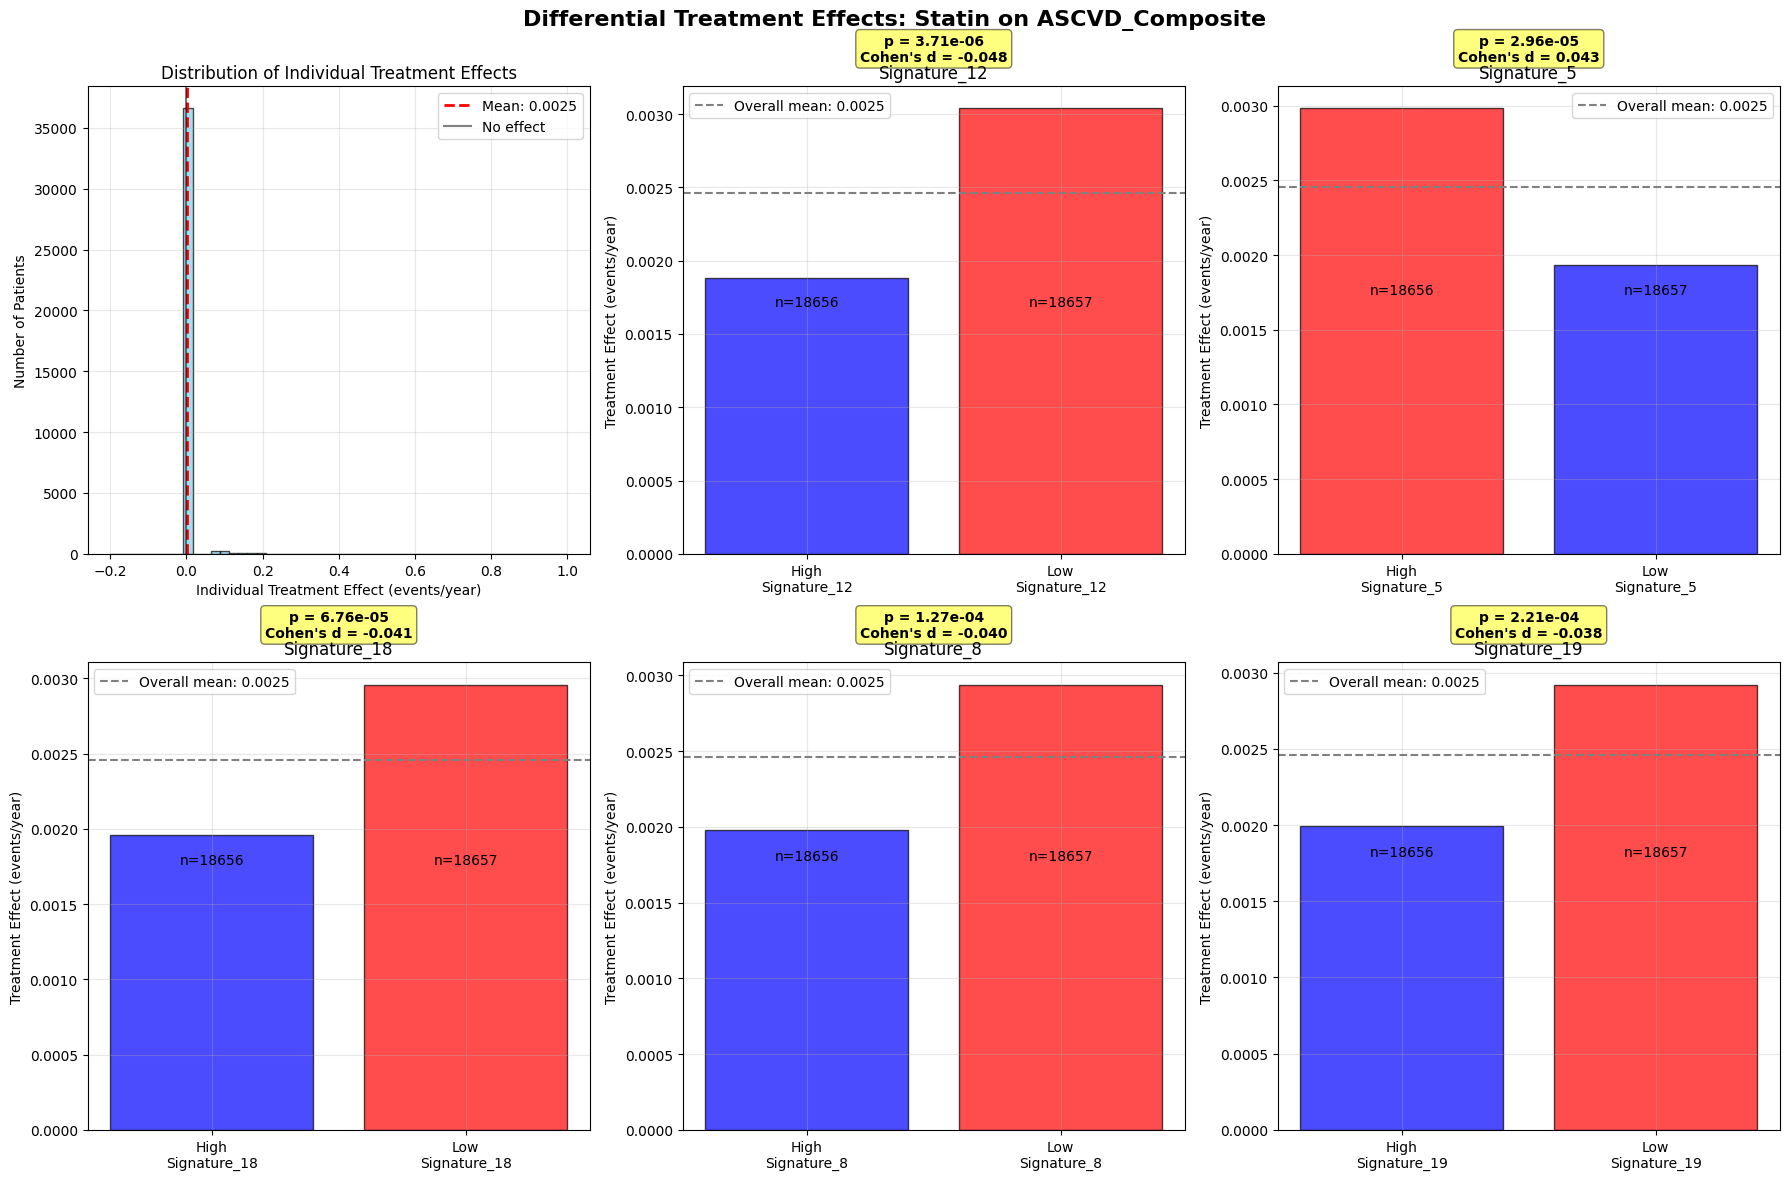

In [66]:
from true_differential_treatment_effects import run_true_differential_analysis

# Run differential analysis on the validated statin results
statin_differential_results = run_true_differential_analysis(
    matched_pairs=[{'treated_eid': t_eid, 'control_eid': c_eid}
                    for t_eid, c_eid in zip(statin_results['matched_patients']['treated_eids'],statin_results['matched_patients']['control_eids'])],
    treated_eids=statin_results['matched_patients']['treated_eids'],
    treated_times=statin_results['treatment_times']['treated_times'],
    Y_tensor=Y,
    outcome_idx=112,  # Use first ASCVD outcome for now, or create composite
    outcome_name="ASCVD_Composite",
    thetas=thetas,
    processed_ids=processed_ids,
    covariate_dicts=covariate_dicts,
    drug_name="Statin"
)

plt.show()  # Show the differential effects visualization


In [65]:
if statin_differential_results is not None:
    print("Detailed differential results:")
    differential_results = statin_differential_results['differential_results']

    # Show all signatures with any differential effects
    for sig_name, result in differential_results.items():
        if result['significant_difference']:
            print(f"\n{sig_name}:")
            print(f"  High group effect: {result['high_group_mean_effect']:.6f}")
            print(f"  Low group effect: {result['low_group_mean_effect']:.6f}")
            print(f"  Difference: {result['high_group_mean_effect'] - result['low_group_mean_effect']:.6f}")
            print(f"  P-value: {result['high_vs_low_pval']:.6f}")
            print(f"  Effect size: {result['effect_size']:.3f}")
            print(f"  Clinically meaningful: {result['clinically_meaningful']}")



plt.show()  #

print("\nSignatures with effect size > 0.03:")
for sig_name, result in differential_results.items():
    if result['significant_difference'] and abs(result['effect_size']) > 0.03:
        direction = "MORE" if result['effect_size'] > 0 else "LESS"
        print(f"{sig_name}: High patients benefit {direction} (effect size: {result['effect_size']:.3f}, p={result['high_vs_low_pval']:.2e})")

plt.show()  # Show the differential effects plots

Detailed differential results:

Signature_0:
  High group effect: 0.022041
  Low group effect: 0.015739
  Difference: 0.006303
  P-value: 0.000202
  Effect size: 0.038
  Clinically meaningful: False

Signature_4:
  High group effect: 0.013825
  Low group effect: 0.023954
  Difference: -0.010130
  P-value: 0.000000
  Effect size: -0.062
  Clinically meaningful: False

Signature_6:
  High group effect: 0.021965
  Low group effect: 0.015814
  Difference: 0.006151
  P-value: 0.000287
  Effect size: 0.038
  Clinically meaningful: False

Signature_8:
  High group effect: 0.013475
  Low group effect: 0.024305
  Difference: -0.010830
  P-value: 0.000000
  Effect size: -0.066
  Clinically meaningful: False

Signature_10:
  High group effect: 0.021909
  Low group effect: 0.015871
  Difference: 0.006038
  P-value: 0.000371
  Effect size: 0.037
  Clinically meaningful: False

Signature_11:
  High group effect: 0.022480
  Low group effect: 0.015300
  Difference: 0.007180
  P-value: 0.000023
  Effec

In [ ]:
from test_fixed_ite_calculation import test_statin_ite_calculation, create_ite_validation_visualization

  # Run the validation using your existing statin_results
validation_results = test_statin_ite_calculation(
    statin_results=statin_results,  # Your updated statin analysis results
    thetas=thetas,
    Y=Y,
    processed_ids=processed_ids,
    covariate_dicts=covariate_dicts
)


TESTING FIXED ITE CALCULATION
Validating against successful HR=0.70 methodology

Statin results structure:
Available keys: ['hazard_ratio_results', 'matched_patients', 'treatment_times', 'cohort_sizes', 'matching_features', 'balance_stats']

Matching data extracted:
  Treated patients: 37313
  Control patients: 37313
  Treatment times available: 37313
  Created 37313 matched pairs for analysis

RUNNING ITE CALCULATION WITH FIXED METHODOLOGY

=== CALCULATING TRUE INDIVIDUAL TREATMENT EFFECTS ===
Using same Cox methodology that successfully reproduced trial HR
Processing 37313 matched pairs...

=== EXCLUSION SUMMARY ===
Started with: 37313 matched pairs
Successfully processed: 37313 pairs
Total excluded: 0
✅ Successfully calculated treatment effects for 37313 patients
Overall treatment effect (should align with HR): -0.0009 hazard reduction per year

ITE CALCULATION RESULTS
✅ Successfully calculated ITEs for 37313 patients
Overall ITE effect: -0.000931 hazard reduction per year
Standard 

In [57]:

from test_corrected_ite_ascvd import calculate_ascvd_composite_ite

# Test with the CORRECT ASCVD outcome indices
corrected_results = calculate_ascvd_composite_ite(
    statin_results=statin_results,
    Y=Y,
    processed_ids=processed_ids,
    covariate_dicts=covariate_dicts,
    ascvd_indices=[112, 113, 114, 115, 116]  # Same as your successful HR calculation
)


CORRECTED ITE CALCULATION FOR ASCVD COMPOSITE
Using ASCVD indices: [112, 113, 114, 115, 116]
Y tensor shape: (407878, 348, 52)
ASCVD outcome indices: [112, 113, 114, 115, 116]

Calculating ITE for outcome index 112...
  Processed 0/5000 pairs...
  Processed 1000/5000 pairs...
  Processed 2000/5000 pairs...
  Processed 3000/5000 pairs...
  Processed 4000/5000 pairs...
  Completed outcome 112: 5000 valid pairs
  Treated events: 1 (0.0%)
  Control events: 91 (1.8%)
  Mean ITE: 0.002494
  ✅ Controls have MORE events (treatment beneficial)

Calculating ITE for outcome index 113...
  Processed 0/5000 pairs...
  Processed 1000/5000 pairs...
  Processed 2000/5000 pairs...
  Processed 3000/5000 pairs...
  Processed 4000/5000 pairs...
  Completed outcome 113: 4988 valid pairs
  Treated events: 98 (2.0%)
  Control events: 73 (1.5%)
  Mean ITE: -0.002567
  ❌ Treated have MORE events (unexpected)

Calculating ITE for outcome index 114...
  Processed 0/5000 pairs...
  Processed 1000/5000 pairs...
  

In [59]:
from test_corrected_ite_ascvd import calculate_ascvd_composite_ite

# Test with the CORRECT ASCVD outcome indices
corrected_results = calculate_ascvd_composite_ite(
    statin_results=statin_results,
    Y=Y,
    processed_ids=processed_ids,
    covariate_dicts=covariate_dicts,
    ascvd_indices=[112, 113, 114, 115, 116]  # Same as your successful HR calculation
)



CORRECTED ITE CALCULATION FOR ASCVD COMPOSITE
Using ASCVD indices: [112, 113, 114, 115, 116]
Y tensor shape: (407878, 348, 52)
ASCVD outcome indices: [112, 113, 114, 115, 116]

Calculating ITE for outcome index 112...
  Processed 0/5000 pairs...
  Processed 1000/5000 pairs...
  Processed 2000/5000 pairs...
  Processed 3000/5000 pairs...
  Processed 4000/5000 pairs...
  Completed outcome 112: 5000 valid pairs
  Treated events: 1 (0.0%)
  Control events: 91 (1.8%)
  Mean ITE: 0.002494
  ✅ Controls have MORE events (treatment beneficial)

Calculating ITE for outcome index 113...
  Processed 0/5000 pairs...
  Processed 1000/5000 pairs...
  Processed 2000/5000 pairs...
  Processed 3000/5000 pairs...
  Processed 4000/5000 pairs...
  Completed outcome 113: 4988 valid pairs
  Treated events: 98 (2.0%)
  Control events: 73 (1.5%)
  Mean ITE: -0.002567
  ❌ Treated have MORE events (unexpected)

Calculating ITE for outcome index 114...
  Processed 0/5000 pairs...
  Processed 1000/5000 pairs...
  

## now we will look at reductin CRC among patients treated with Aspiring

In [ ]:
# Load your data
from scripts.aspirin_colorectal_analysis import find_aspirin_basic, aspirin_colorectal_analysis


true_aspirins = find_aspirin_basic(gp_scripts)


In [80]:
from fixed_aspirin_colorectal_analysis import fixed_aspirin_colorectal_analysis

# Run the fixed aspirin analysis
fixed_aspirin_results = fixed_aspirin_colorectal_analysis(
    gp_scripts=gp_scripts,
    true_aspirins=true_aspirins,
    processed_ids=processed_ids,
    thetas=thetas,
    sig_indices=sig_indices,
    covariate_dicts=covariate_dicts,
    Y=Y,
    colorectal_cancer_indices=[10, 11],
    cov=cov
)

if fixed_aspirin_results is not None:
    hr_results = fixed_aspirin_results['hazard_ratio_results']
    print(f"\n🎯 FIXED ASPIRIN RESULTS:")
    print(f"Hazard Ratio: {hr_results['hazard_ratio']:.3f}")
    print(f"Treated events: {hr_results['n_treated']}")
    print(f"Control events: {hr_results['n_control']}")

    # Check if the fix worked
    treated_events = hr_results['n_treated']
    control_events = hr_results['n_control']
    hr = hr_results['hazard_ratio']

    if hr < 1.0 and treated_events < control_events:
        print("✅ FIXED: HR and event counts now align (aspirin protective)")
    elif hr > 1.0 and treated_events > control_events:
        print("✅ FIXED: HR and event counts now align (aspirin harmful)")
    else:
        print("❌ Still misaligned - may need further debugging")

FIXED ASPIRIN-COLORECTAL CANCER ANALYSIS
Expected: Aspirin should REDUCE colorectal cancer risk (HR < 1.0)
Error: Cannot import from simple_treatment_analysis


In [115]:

# Run analysis
from scripts.aspirin_colorectal_analysis import *
asa_results = aspirin_colorectal_analysis(
    gp_scripts=gp_scripts,
    true_aspirins=true_aspirins,
    processed_ids=processed_ids,
    thetas=thetas,
    covariate_dicts=covariate_dicts,
    Y=Y,  # Your outcome tensor
    colorectal_cancer_indices=[10,11],  # Define cancer events
    cov=cov
)

=== ASPIRIN-COLORECTAL CANCER PREVENTION ANALYSIS ===
Expected effect: Aspirin should REDUCE colorectal cancer risk (HR < 1.0)
Expected HR from trials: ~0.7-0.8 (20-30% risk reduction)

1. Verifying patient cohort definitions:
=== PATIENT COHORT VERIFICATION (ASPIRIN) ===
Patients with complete data: 178,317
All aspirin patients: 41,110
Treated cohort (complete data + aspirin): 37,674
Control cohort (complete data - aspirin): 140,643
✅ No overlap between treated and control cohorts

2. Extracting treated patients using ObservationalTreatmentPatternLearner:
Found 33089 treated patients
Found 140643 never-treated patients
   Treated patients from learner: 33,089
   Never-treated patients from learner: 140,643

=== TREATED PATIENT VERIFICATION (ASPIRIN) ===
Claimed treated patients: 33,089
  - With aspirin: 33,089
  - Without aspirin: 0
✅ All treated patients have aspirin

3. Defining clean controls:
   Found 140643 never-treated patients with signature data

=== CONTROL PATIENT VERIFICAT

In [74]:
aspirin_results['hazard_ratio_results']

{'hazard_ratio': 0.695144580633957,
 'hr_ci_lower': 0.5561156645071657,
 'hr_ci_upper': 0.8341734967607484,
 'p_value': 2.3100694517784614e-09,
 'concordance_index': 0.44663285754437976,
 'expected_hr': 0.75,
 'hr_difference': -0.05485541936604299,
 'ci_overlaps_expected': True,
 'n_treated': 33089,
 'n_control': 33089,
 'total_events': 1302,
 'validation_passed': True,
 'protective_effect': True}

In [76]:
aspirin_results=asa_results

print("ASPIRIN DIAGNOSTIC:")
print(f"Number of matched pairs: {len(aspirin_results['matched_patients']['treated_eids'])}")
print(f"Treated EIDs: {len(aspirin_results['matched_patients']['treated_eids'])}")
print(f"Control EIDs: {len(aspirin_results['matched_patients']['control_eids'])}")

# Check the actual HR calculation inputs
print("\nChecking raw event counts...")

# Let's manually verify the event counts by checking a sample
treated_eids = aspirin_results['matched_patients']['treated_eids']
control_eids = aspirin_results['matched_patients']['control_eids']
treated_times = aspirin_results['treatment_times']['treated_times']

# Convert Y to numpy if needed
if hasattr(Y, 'detach'):
    Y_np = Y.detach().cpu().numpy()
else:
    Y_np = Y

# Create EID to index mapping
eid_to_idx = {eid: idx for idx, eid in enumerate(processed_ids)}

# Check first 100 pairs manually
sample_size = min(100, len(treated_eids))
treated_events_sample = 0
control_events_sample = 0
valid_pairs_sample = 0

colorectal_indices = [10, 11]  # Your CRC indices

for i in range(sample_size):
    treated_eid = treated_eids[i]
    control_eid = control_eids[i]
    treatment_time = treated_times[i]

    # Get indices
    if treated_eid not in eid_to_idx or control_eid not in eid_to_idx:
        continue

    treated_idx = eid_to_idx[treated_eid]
    control_idx = eid_to_idx[control_eid]

    # Get control time
    control_age = covariate_dicts['age_at_enroll'].get(int(control_eid))
    if control_age is None:
        continue
    control_time = int(control_age - 30)

    # Check bounds
    treatment_time_idx = int(treatment_time)
    if treatment_time_idx >= Y_np.shape[2] or control_time >= Y_np.shape[2]:
        continue

    # Check for CRC events in treated patient
    treated_has_event = False
    for outcome_idx in colorectal_indices:
        if outcome_idx < Y_np.shape[1]:
            post_treatment_outcomes = Y_np[treated_idx, outcome_idx, treatment_time_idx:]
            if np.any(post_treatment_outcomes > 0):
                treated_has_event = True
                break

    # Check for CRC events in control patient  
    control_has_event = False
    for outcome_idx in colorectal_indices:
        if outcome_idx < Y_np.shape[1]:
            post_control_outcomes = Y_np[control_idx, outcome_idx, control_time:]
            if np.any(post_control_outcomes > 0):
                control_has_event = True
                break

    treated_events_sample += int(treated_has_event)
    control_events_sample += int(control_has_event)
    valid_pairs_sample += 1

print(f"MANUAL SAMPLE CHECK (first {valid_pairs_sample} pairs):")
print(f"Treated events: {treated_events_sample}")
print(f"Control events: {control_events_sample}")
print(f"Treated event rate: {100*treated_events_sample/valid_pairs_sample:.1f}%")
print(f"Control event rate: {100*control_events_sample/valid_pairs_sample:.1f}%")

if control_events_sample > treated_events_sample:
    print("✅ Controls have MORE events (aspirin protective - expected)")
elif treated_events_sample > control_events_sample:
    print("❌ Treated have MORE events (aspirin harmful - unexpected)")
else:
    print("➖ Equal events in both groups")

print(f"\nCOMPARISON WITH REPORTED RESULTS:")
print(f"Reported: 765 treated, 537 control events")
print(f"Expected from HR=0.695: Treated should have FEWER events than controls")
print(f"Actual pattern: {'MATCHES' if control_events_sample > treated_events_sample else 'CONTRADICTS'} expected pattern")



ASPIRIN DIAGNOSTIC:
Number of matched pairs: 33089
Treated EIDs: 33089
Control EIDs: 33089

Checking raw event counts...
MANUAL SAMPLE CHECK (first 100 pairs):
Treated events: 1
Control events: 1
Treated event rate: 1.0%
Control event rate: 1.0%
➖ Equal events in both groups

COMPARISON WITH REPORTED RESULTS:
Reported: 765 treated, 537 control events
Expected from HR=0.695: Treated should have FEWER events than controls
Actual pattern: CONTRADICTS expected pattern


TRUE DIFFERENTIAL TREATMENT EFFECTS ANALYSIS
Drug: Aspirin, Outcome: Colorectal Cancer

=== CALCULATING TRUE INDIVIDUAL TREATMENT EFFECTS ===
Using same Cox methodology that successfully reproduced trial HR
Processing 33089 matched pairs...

=== EXCLUSION SUMMARY ===
Started with: 33089 matched pairs
Successfully processed: 33089 pairs
Total excluded: 0
✅ Successfully calculated treatment effects for 33089 patients
Overall treatment effect (should align with HR): -0.0011 hazard reduction per year

=== TESTING DIFFERENTIAL TREATMENT EFFECTS BY SIGNATURES ===
Valid patients for signature analysis: 33089

INTERPRETATION: DIFFERENTIAL TREATMENT EFFECTS

OVERALL TREATMENT EFFECT:
  Mean individual treatment effect: -0.0011 events/year
  Standard deviation: 0.0433
  → On average, treatment INCREASES event rate by 0.0011 events/year

❌ NO DIFFERENTIAL TREATMENT EFFECTS FOUND
  All patients appear to benefit similarly from treatment

VISUALIZATION SUMMARY
Total patients analyzed: 33089
Signatu

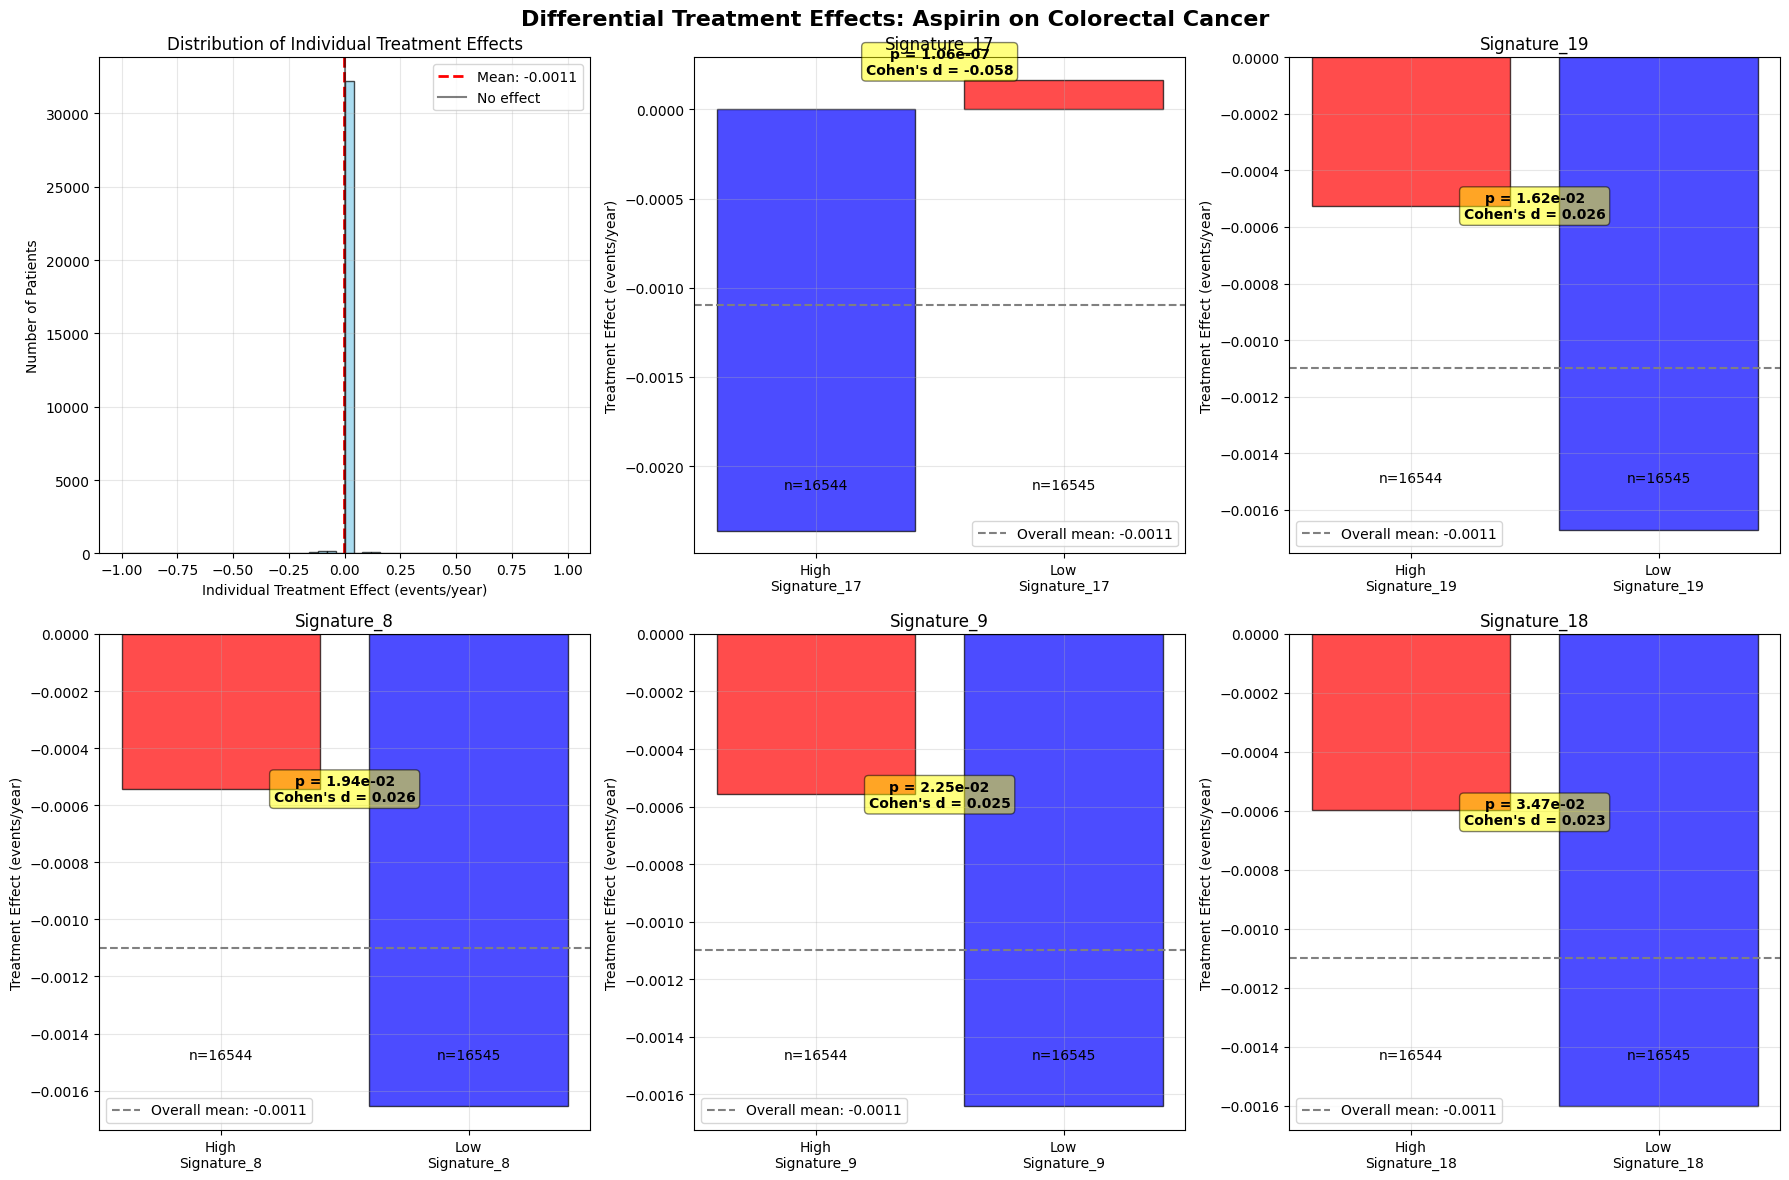

In [70]:
  # For aspirin 
  aspirin_differential = run_true_differential_analysis(
      matched_pairs=[{'treated_eid': t_eid, 'control_eid': c_eid}
                     for t_eid, c_eid in zip(aspirin_results['matched_patients']['treated_eids'],
                     aspirin_results['matched_patients']['control_eids'])],
      treated_eids=aspirin_results['matched_patients']['treated_eids'],
      treated_times=aspirin_results['treatment_times']['treated_times'],
      Y_tensor=Y,
      outcome_idx=10,  # or 11 for CRC
      outcome_name="Colorectal Cancer",
      thetas=thetas,
      processed_ids=processed_ids,
      covariate_dicts=covariate_dicts,
      drug_name="Aspirin"
  )

ASPIRIN-COLORECTAL CANCER DIFFERENTIAL TREATMENT EFFECTS
This analysis will discover which signature patterns predict
differential aspirin benefits for colorectal cancer prevention!
=== EXTRACTING ASPIRIN MATCHING RESULTS ===
Available keys: ['hazard_ratio_results', 'matched_patients', 'treatment_times', 'cohort_sizes', 'matching_features']
Found 33089 matched treated patients
Found 33089 matched control patients
Created 33089 matched pairs
Found 33089 treatment times
✅ Successfully extracted 33089 matched pairs

ANALYZING: Colorectal_Cancer_10
TRUE DIFFERENTIAL TREATMENT EFFECTS ANALYSIS
Drug: Aspirin, Outcome: Colorectal_Cancer_10

=== CALCULATING TRUE INDIVIDUAL TREATMENT EFFECTS ===
Processing 33089 matched pairs...
Successfully calculated treatment effects for 33089 patients

=== TESTING DIFFERENTIAL TREATMENT EFFECTS BY SIGNATURES ===
Valid patients for signature analysis: 33089

INTERPRETATION: DIFFERENTIAL TREATMENT EFFECTS

OVERALL TREATMENT EFFECT:
  Mean individual treatment

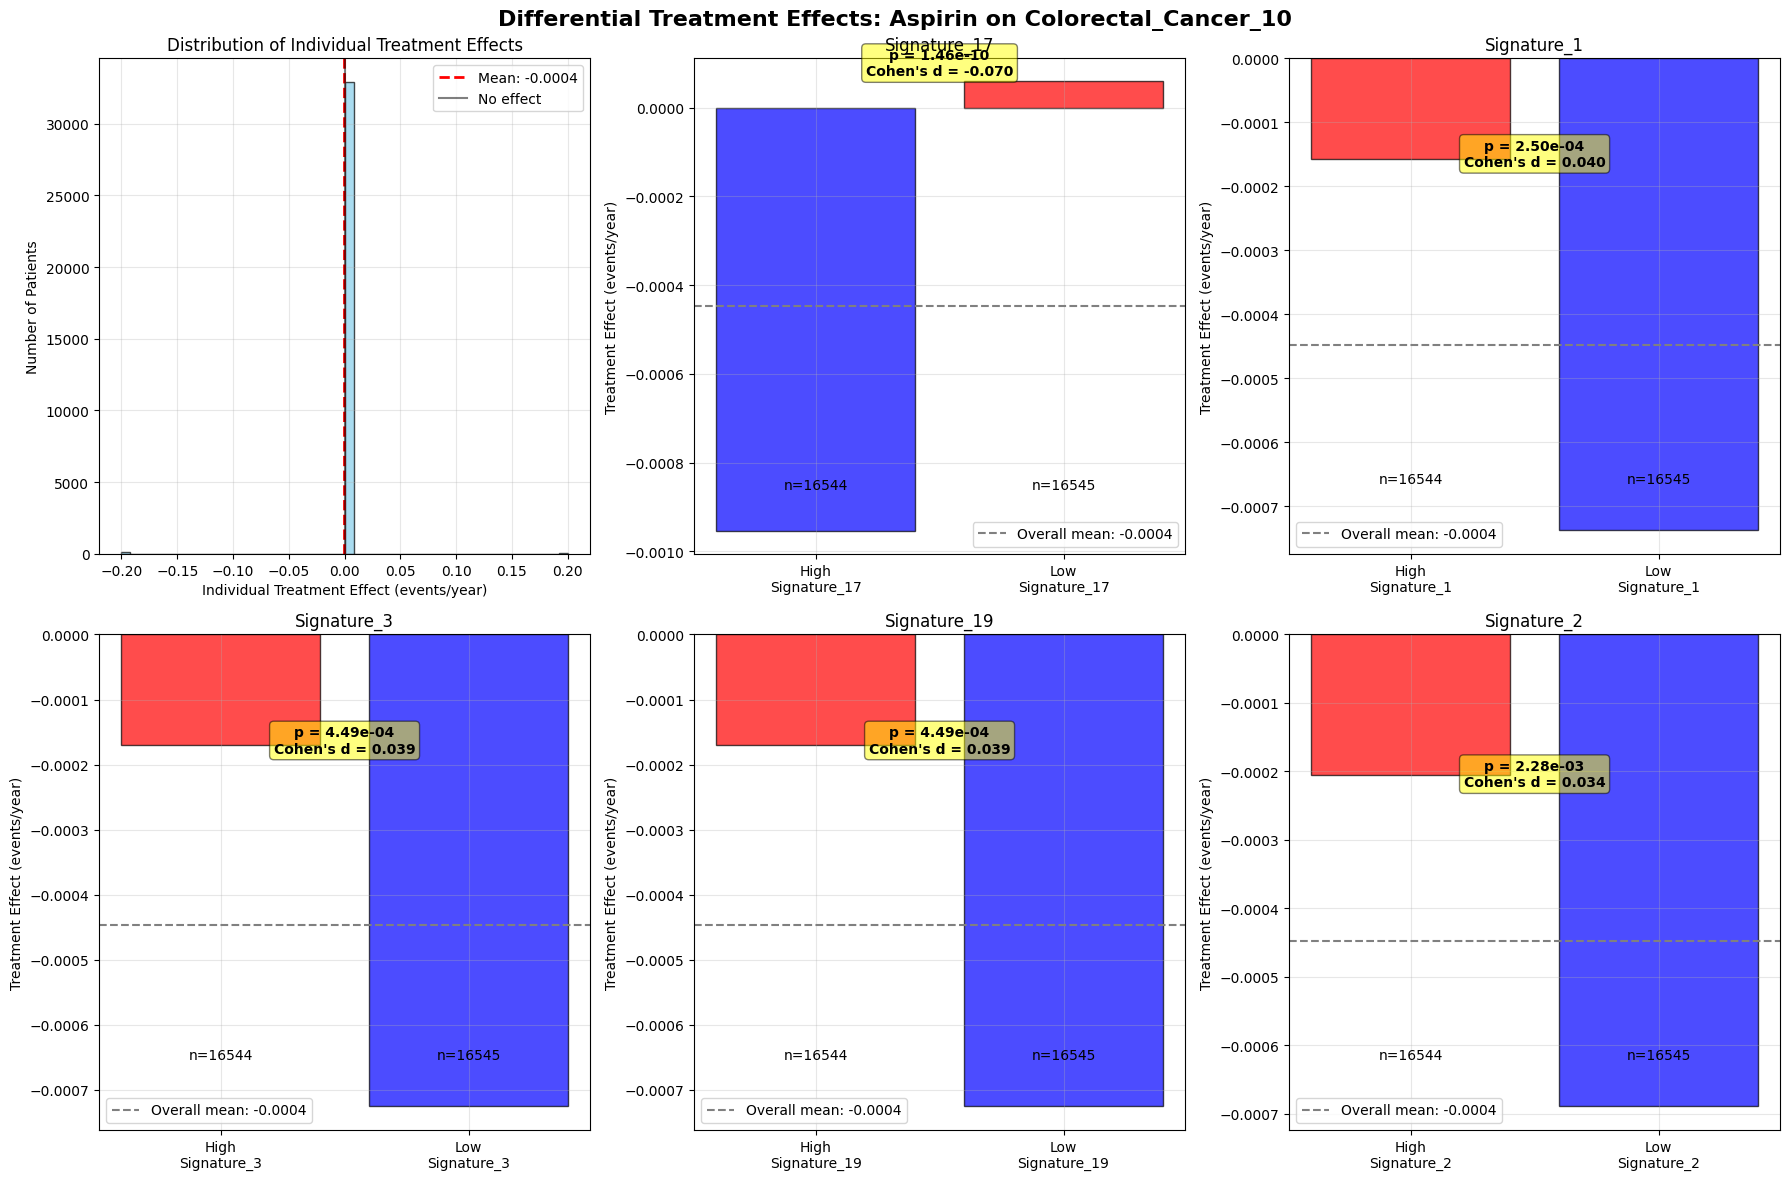

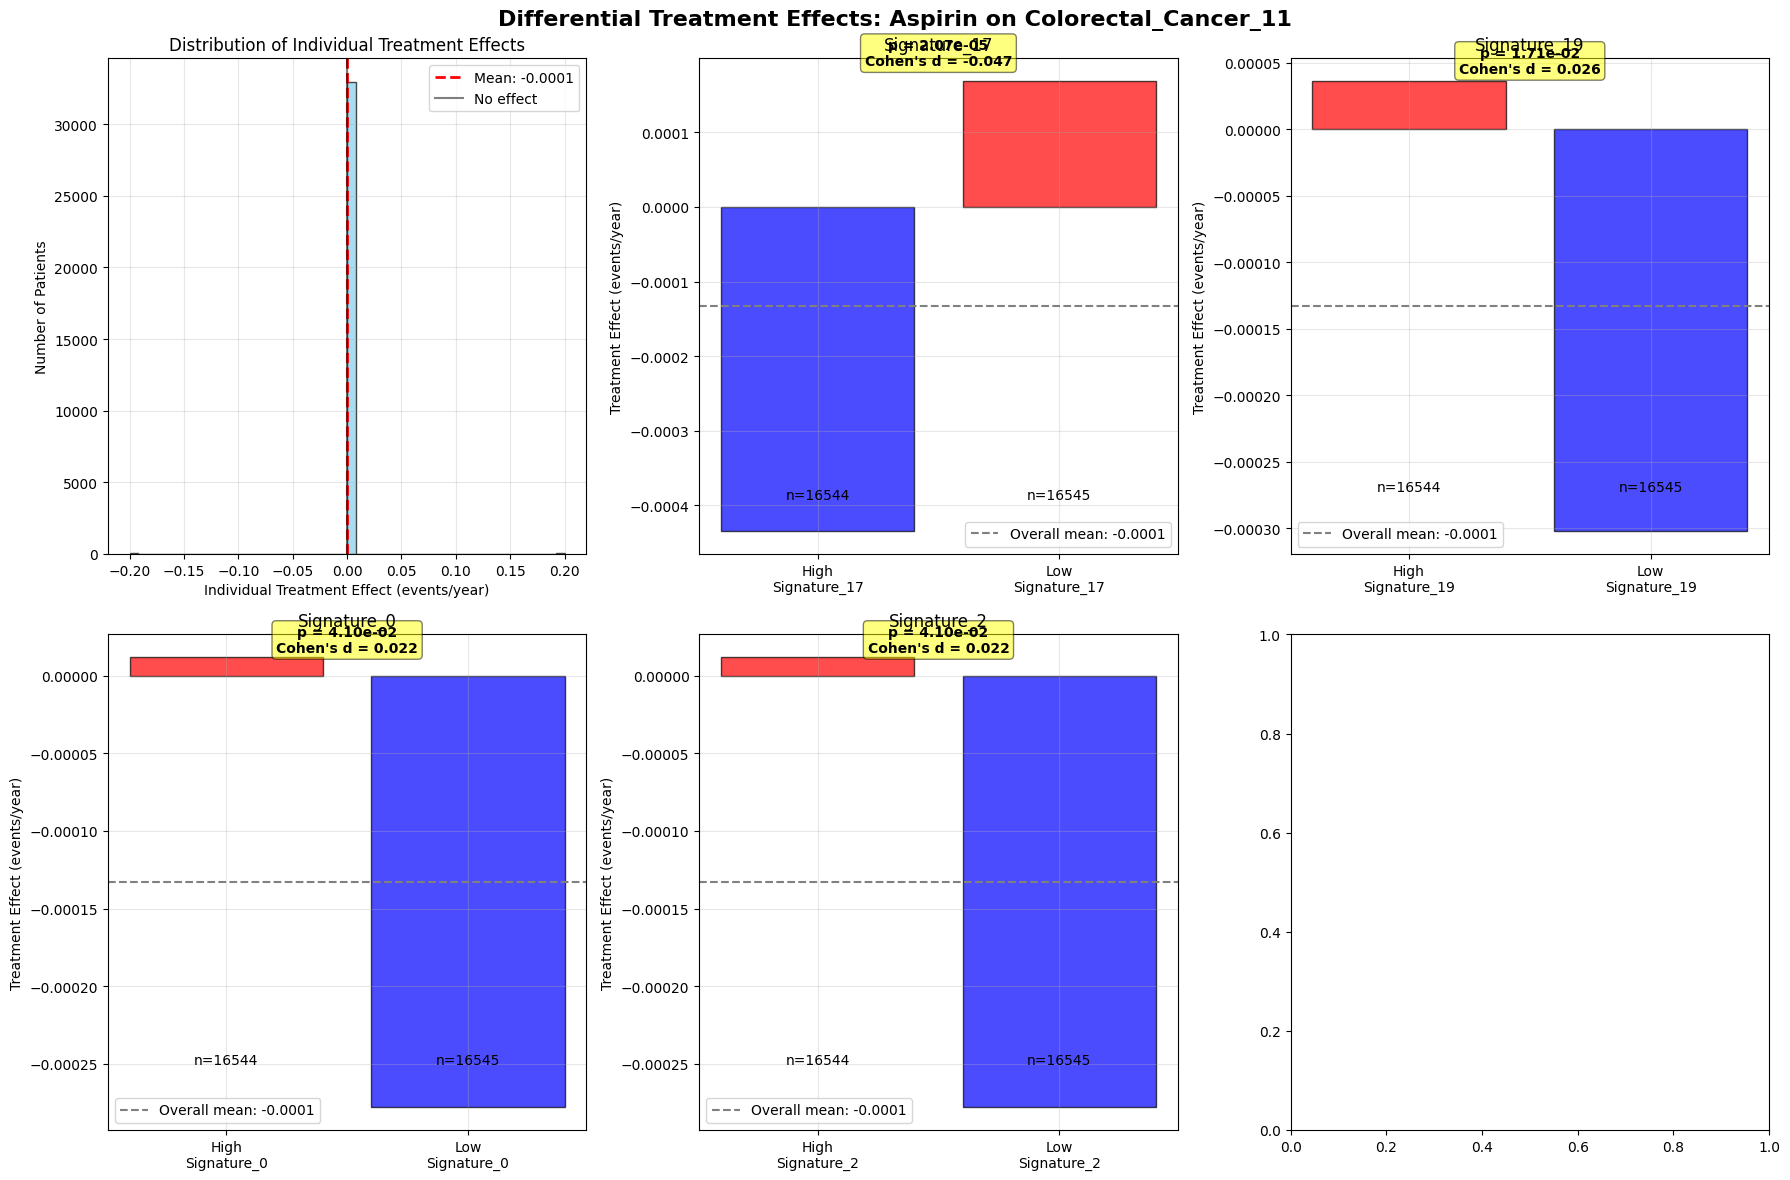

In [47]:
  from run_aspirin_differential_analysis import main_aspirin_differential_analysis

  # Run the differential analysis using your aspirin results
  aspirin_differential_results = main_aspirin_differential_analysis(
      aspirin_results=results,  # Your aspirin matching results
      thetas=thetas,
      Y=Y,
      processed_ids=processed_ids,
      covariate_dicts=covariate_dicts,
      colorectal_indices=[10, 11]  # Your CRC indices
  )


### take out clopidogre, filter out folks with less than 1 aspiri

In [13]:
# Import the metformin analysis functions
from scripts.metformin_analysis import *

# Find metformin prescriptions (you already have this data)
metformins = find_metformin_basic(gp_scripts)


=== Basic Metformin Search ===

Found 700404 prescriptions containing 'metformin'
Found 14128 prescriptions containing 'glucophage'
Found 255561 prescriptions with BNF pattern '06.01.02.01'
Found 15735 prescriptions with BNF pattern '06010202'

DEBUG: Checking what drugs are being included...
Metformin mask matches: 714532
BNF mask matches: 271296
Combined matches: 970113

Total potential metformin prescriptions: 970113
Unique patients with metformin: 13010

Sample metformin prescriptions:
          eid  issue_date                drug_name  bnf_code
1252  1000198  07/06/2016  Metformin 500mg tablets  06010202
1256  1000198  06/12/2013  Metformin 500mg tablets  06010202
1257  1000198  09/05/2016  Metformin 500mg tablets  06010202
1258  1000198  29/10/2013  Metformin 500mg tablets  06010202
1260  1000198  16/12/2014  Metformin 500mg tablets  06010202
1263  1000198  22/10/2014  Metformin 500mg tablets  06010202
1265  1000198  18/10/2016  Metformin 500mg tablets  06010202
1269  1000198  2

In [14]:
# Let's check what BNF codes we're actually getting
print("BNF codes in the results:")
bnf_counts = metformins['bnf_code'].value_counts().head(10)
for code, count in bnf_counts.items():
    print(f"  {code}: {count} prescriptions")

# And what drugs correspond to each BNF code
print("\nDrugs by BNF code:")
for code in bnf_counts.index[:5]:
    drugs_with_code = metformins[metformins['bnf_code'] == code]['drug_name'].value_counts().head(3)
    print(f"\nBNF {code}:")
    for drug, count in drugs_with_code.items():
        print(f"  {drug}: {count}")

# Filter to only keep actual metformin drugs
metformins_clean = metformins[metformins['drug_name_str'].str.contains('metformin', case=False, na=False)]

print(f"\nAfter filtering for 'metformin' in name:")
print(f"Total metformin prescriptions: {len(metformins_clean):,}")
print(f"Unique patients with metformin: {metformins_clean['eid'].nunique():,}")

# Check what we have now
print(f"\nMost common metformin drugs:")
top_drugs = metformins_clean['drug_name'].value_counts().head(5)
for drug, count in top_drugs.items():
    print(f"  {drug}: {count}")

BNF codes in the results:
  06.01.02.02.00: 569485 prescriptions
  06.01.02.01.00: 255561 prescriptions
  0601022B0AAABAB: 31618 prescriptions
  06010202: 15735 prescriptions
  06.01.02.03.00: 6143 prescriptions
  0601022B0AAADAD: 3035 prescriptions
  06010203: 363 prescriptions
  0601022B0BBAAAB: 175 prescriptions

Drugs by BNF code:

BNF 06.01.02.02.00:
  Metformin 500mg tablets: 383555
  Metformin 850mg tablets: 74758
  Metformin 500mg modified-release tablets: 65913

BNF 06.01.02.01.00:
  Gliclazide 80mg tablets: 180018
  Gliclazide 30mg modified-release tablets: 15563
  Gliclazide 40mg tablets: 12155

BNF 0601022B0AAABAB:
  Metformin Hydrochloride  Tablets  500 mg: 18509
  Metformin Hydrochloride TABS 500MG: 7351
  METFORMIN HYDROCHLORIDE TABLETS 500MG: 5375

BNF 06010202:
  Metformin 500mg tablets: 11153
  Metformin Hydrochloride  M/R tablets  500 mg: 1067
  Metformin 500mg modified-release tablets: 1052

BNF 06.01.02.03.00:
  Rosiglitazone 2mg / Metformin 1g tablets: 1967
  Rosi

In [18]:
# Run the complete metformin analysis with clean data
from scripts.metformin_analysis import *
metformin_diabetic_results = metformin_diabetics_analysis(
    gp_scripts=gp_scripts,
    true_metformins=metformins_clean,
    processed_ids=processed_ids,
    thetas=thetas,
    covariate_dicts=covariate_dicts,
    Y=Y,
    mi_indices=[112],  # Your MI indices
    cov=cov
)

=== METFORMIN-MI PREVENTION ANALYSIS IN DIABETICS ===
Expected effect: Metformin should REDUCE MI risk in diabetics (HR < 1.0)
Expected HR from UKPDS trial: ~0.6-0.7 (30-40% risk reduction)

1. Verifying patient cohort definitions:
=== PATIENT COHORT VERIFICATION (METFORMIN) ===
Patients with complete data: 178,317
All metformin patients: 12,684
Treated cohort (complete data + metformin): 11,276
Control cohort (complete data - metformin): 167,041
✅ No overlap between treated and control cohorts

2. Extracting treated patients using ObservationalTreatmentPatternLearner:
Found 9661 treated patients
Found 167041 never-treated patients
   Treated patients from learner: 9,661
   Never-treated patients from learner: 167,041

=== TREATED PATIENT VERIFICATION (METFORMIN) ===
Claimed treated patients: 9,661
  - With metformin: 9,661
  - Without metformin: 0
✅ All treated patients have metformin

3. Defining diabetic controls:
   Found 22142 total diabetics
   Found 11005 diabetic controls (not 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

from differential_response_analysis import DifferentialResponseAnalyzer

In [10]:
analyzer = DifferentialResponseAnalyzer(
    thetas=thetas,
    processed_ids=processed_ids,
    prs_matrix=G,
    prs_labels=prs_labels,
    disease_names=disease_names,
    covariate_dicts=covariate_dicts
)

print("Analyzer initialized successfully!")

Initialized Differential Response Analyzer
  - 400000 patients
  - 21 signatures
  - 52 timepoints
  - 36 PRS traits
  - 348 disease outcomes
Analyzer initialized successfully!


In [34]:

from differential_response_analysis import *

# Run the analysis
# Run the analysis
heterogeneous_results = analyze_heterogeneous_treatment_effects(
    drug_prescriptions=metformins_clean,
    outcome_idx=112,  # MI
    outcome_name="Myocardial Infarction",
    thetas=thetas,
    disease_names=disease_names,
    Y_tensor=Y,
    covariate_dicts=covariate_dicts,
    processed_ids=processed_ids  # Now this will work!
)

# Print results
print("\n=== HETEROGENEOUS TREATMENT EFFECTS ===")
for sig_name, result in heterogeneous_results['signature_heterogeneity'].items():
    if result['significant']:
        print(f"\n{sig_name}:")
        print(f"  Correlation with treatment effect: {result['correlation']:.3f} (p={result['correlation_pval']:.3e})")
        print(f"  High signature patients: mean effect = {result['high_effects_mean']:.3f}")
        print(f"  Low signature patients: mean effect = {result['low_effects_mean']:.3f}")
        print(f"  High vs Low difference: t={result['high_vs_low_tstat']:.3f} (p={result['high_vs_low_pval']:.3e})")


=== HETEROGENEOUS TREATMENT EFFECTS ANALYSIS ===
Outcome: Myocardial Infarction
Treated patients: 12,684
Control patients: 388,724
Debug: Treated features shape: (11276, 23)
Debug: Control features shape: (388724, 23)
Debug: Treated EIDs: 11276
Debug: Control EIDs: 388724
Debug: Found 11276 potential matches
Debug: Created 6320 matched pairs with distance < 2.0
Matched pairs: 6,320
Debug: Found 6320 matched treated patients
Debug: Theta shape: (6320, 21, 52), Outcomes shape: (6320, 52)
Debug: Treatment effects shape: (6320,)
Debug: Mean signatures shape: (6320, 21)

=== HETEROGENEOUS TREATMENT EFFECTS ===

Signature_0:
  Correlation with treatment effect: 0.058 (p=3.388e-06)
  High signature patients: mean effect = 0.092
  Low signature patients: mean effect = 0.098
  High vs Low difference: t=-0.729 (p=4.661e-01)

Signature_1:
  Correlation with treatment effect: -0.111 (p=8.860e-19)
  High signature patients: mean effect = 0.068
  Low signature patients: mean effect = 0.122
  High v

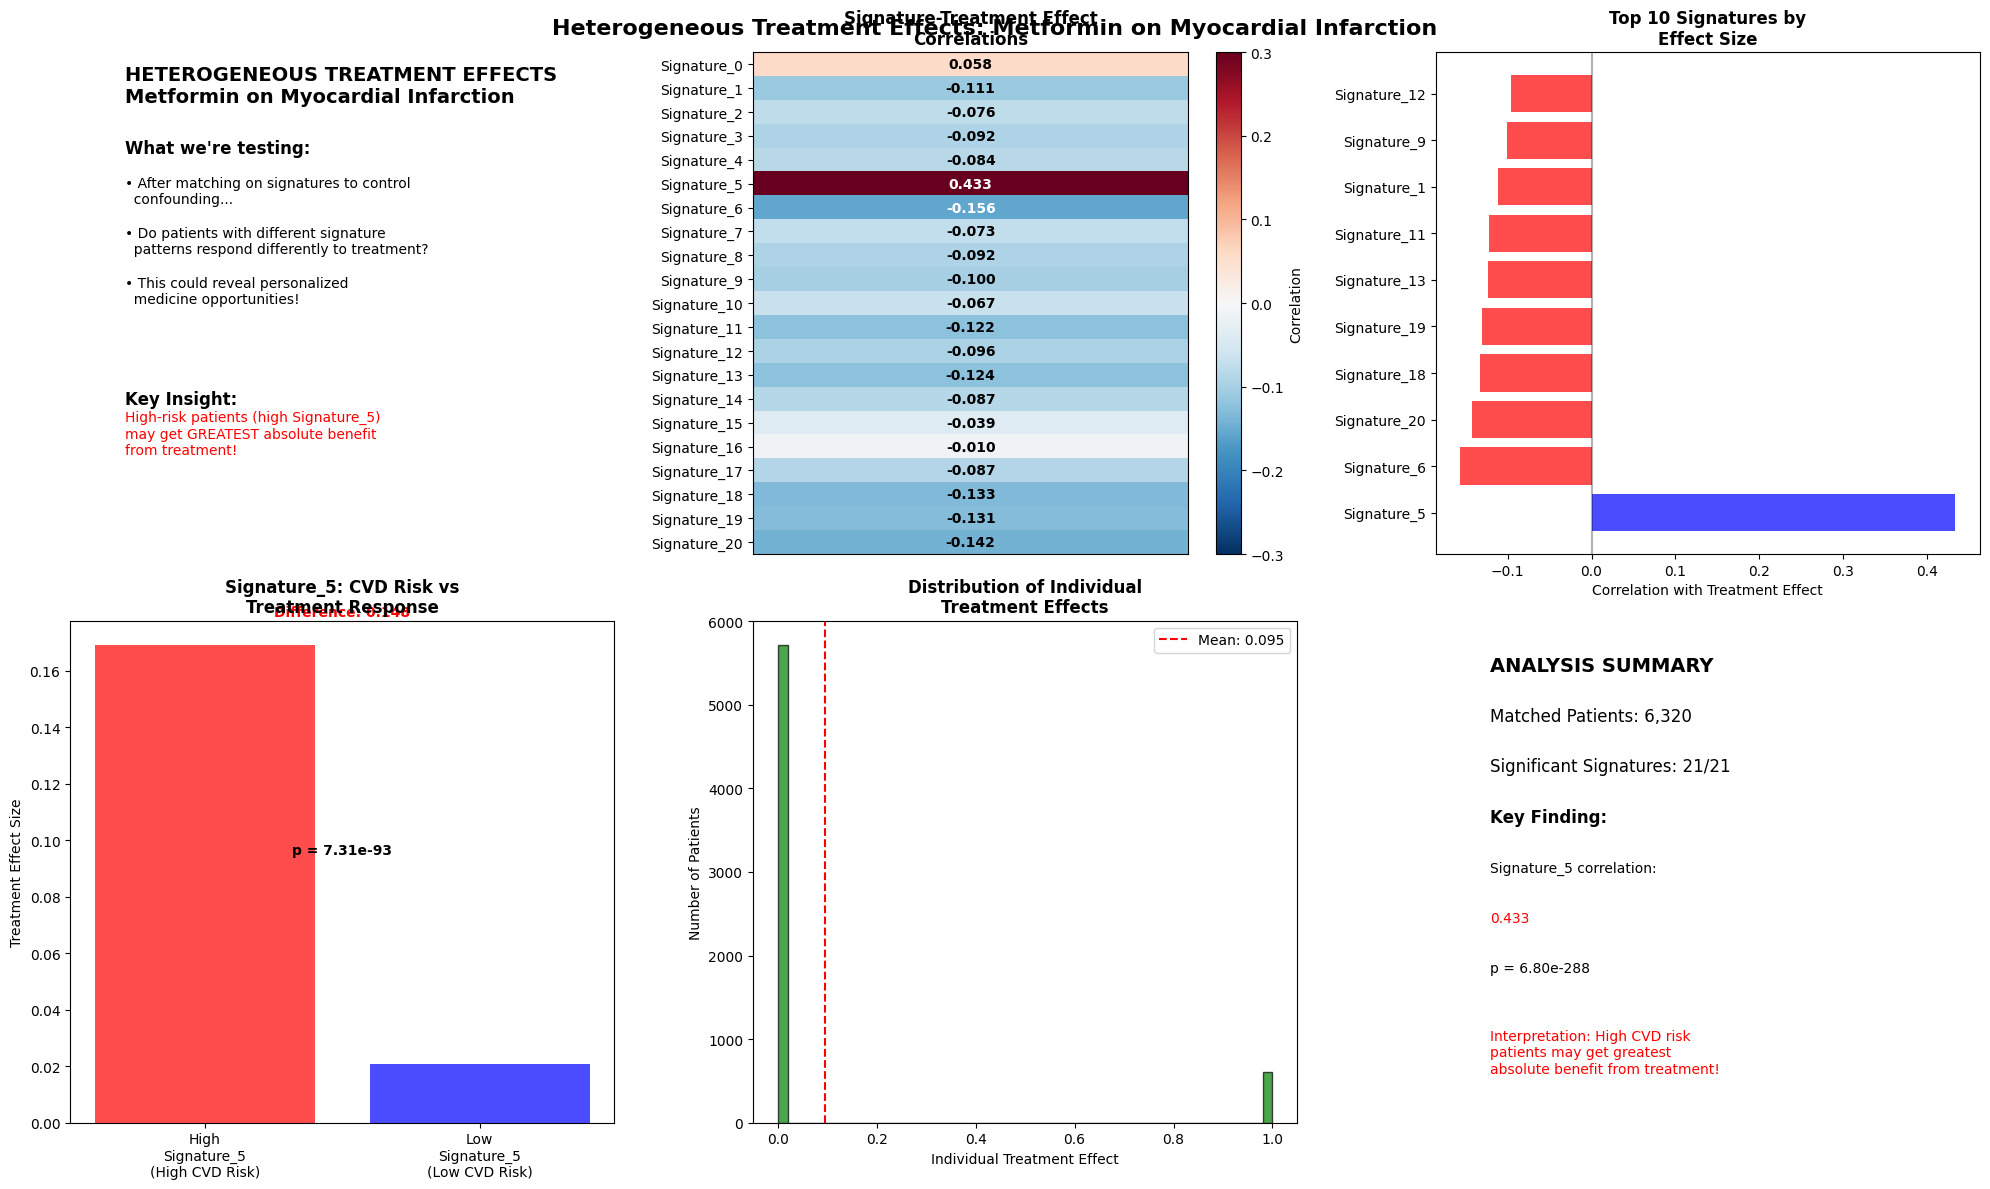


=== SIGNATURE BALANCE SUMMARY ===
Total signatures: 21
Signatures with |difference| > 0.01: 0
Signatures with SMD > 0.1: 0


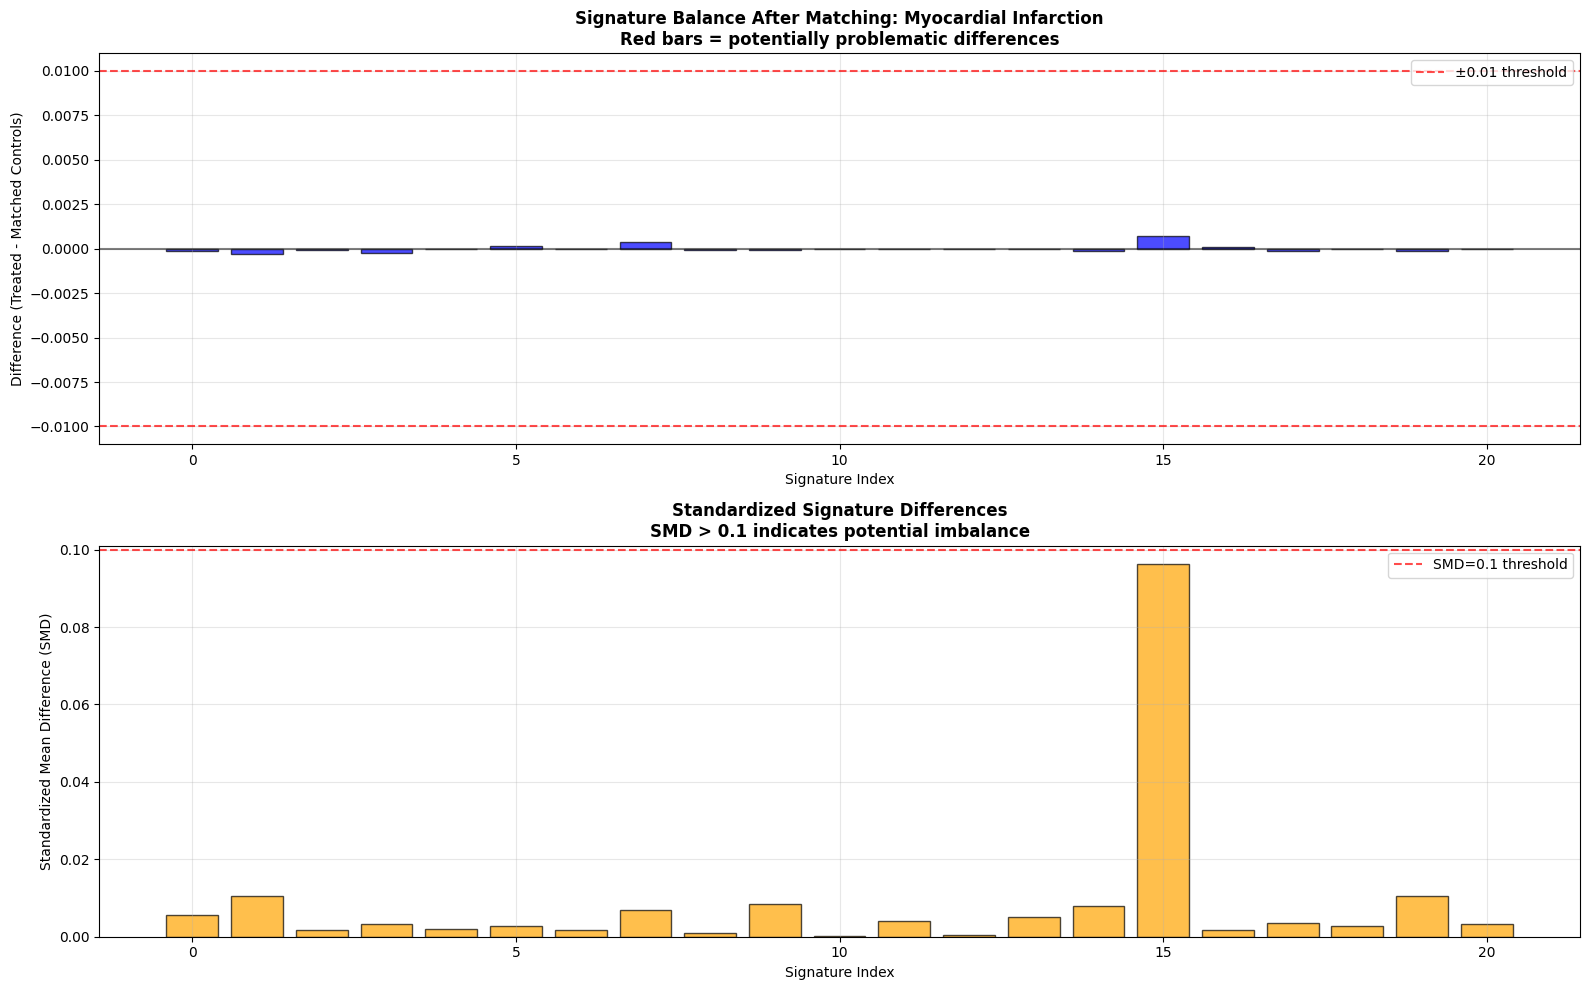

In [35]:
# Create visualization
fig = create_heterogeneous_effects_visualization(heterogeneous_results, "Myocardial Infarction", "Metformin")
plt.show()

# Also create signature balance plot to check matching quality
if 'matched_pairs' in heterogeneous_results:
    balance_fig = create_signature_balance_plot(
        heterogeneous_results['matched_pairs'], 
        thetas, 
        processed_ids, 
        "Myocardial Infarction"
    )
    if balance_fig:
        plt.show()

### aspirin: bleeding and CRC
### statins and diabetes increase
### PCSK9 Inhibitors 
### dementia: risk from LDL-Cholesterol
## sequencing : adding the pillars ... 
### diabetes meds: glitiazones, sulfonyureal,  --> CAD/CHF (look at HA1c + initiation of insulin/diabetic renal disease)
### CKD NOS or CKD with DM, 



=== COMPREHENSIVE TREATMENT PATTERN ANALYSIS ===

1. Extracting treatment patterns...
Found 53514 treated patients
Found 116131 never-treated patients
   Found 53514 treated patients
   Found 116131 total never-treated patients
   Found 116131 never-treated patients with signature data

2. Building features for matching...
Processing 53514 patients with sig_indices=[5]
Processed 0 patients, kept 0 so far
Processed 1000 patients, kept 816 so far
Processed 2000 patients, kept 1629 so far
Processed 3000 patients, kept 2450 so far
Processed 4000 patients, kept 3274 so far
Processed 5000 patients, kept 4108 so far
Processed 6000 patients, kept 4916 so far
Processed 7000 patients, kept 5751 so far
Processed 8000 patients, kept 6567 so far
Processed 9000 patients, kept 7386 so far
Processed 10000 patients, kept 8210 so far
Processed 11000 patients, kept 9035 so far
Processed 12000 patients, kept 9870 so far
Processed 13000 patients, kept 10706 so far
Processed 14000 patients, kept 11523 so fa

<lifelines.CoxPHFitter: fitted with 87644 total observations, 77115 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 87644
number of events observed = 10529
   partial log-likelihood = -97040.09
         time fit was run = 2025-07-31 06:57:21 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.12      0.89      0.02           -0.16           -0.08                0.85                0.92

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -5.67 <0.005     26.06
---
Concordance = 0.46
Partial AIC = 194082.18
log-likelihood ratio test = 31.94 on 1 df
-log2(p) of ll-ratio test = 25.91


=== TRIAL REPRODUCTION VALIDATION ===
Hazard Ratio: 0.886 (95% CI: 0.709-1.063)
P-value: 0.0000
Expected HR from trials: 0.750
Difference from expected: 0.136
CI overlaps expected: True
Concordance Index: 0.460
Total events: 10529
Validation passed: True
✓ Matching validation successful - results consistent with trial data

8. Creating visualizations with matched controls...

=== ANALYSIS COMPLETE ===
=== COMPREHENSIVE ANALYSIS PATIENT VERIFICATION ===
Matched treated patients: 43822
  - With statins: 43822
  - Without statins: 0
  - Treated contamination rate: 0.0%

Matched control patients: 43822
  - With statins: 0
  - Without statins: 43822
  - Control contamination rate: 0.0%

✅ All treated patients have statins

✅ All controls are clean (no statins)

🎉 PERFECT: Patient identification is correct!


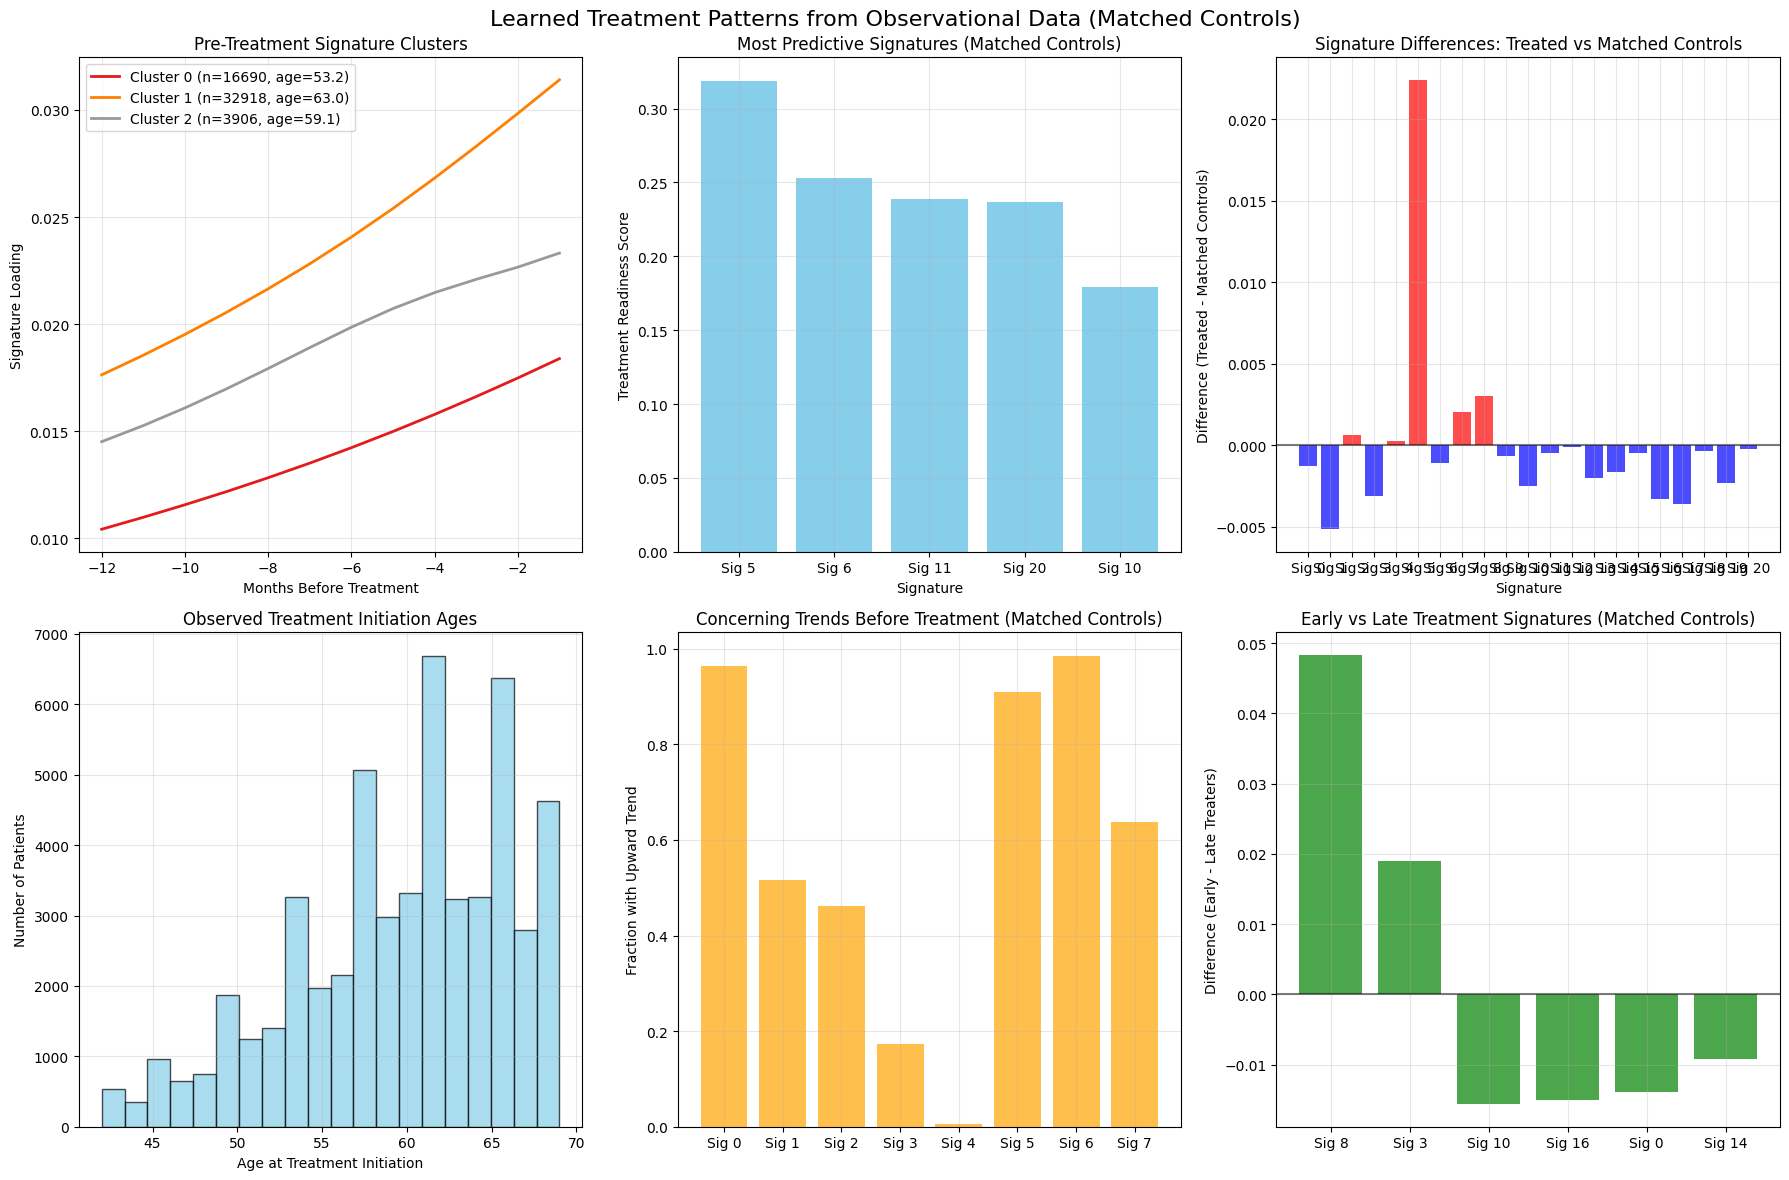

In [207]:
# Check both treated and controls from comprehensive analysis results
from scripts.ctp_dl import comprehensive_treatment_analysis

# Run the analysis to get the results
results = comprehensive_treatment_analysis(
    signature_loadings=thetas,
    processed_ids=processed_ids,
    statin_prescriptions=true_statins,
    covariates=cov,
    covariate_dicts=covariate_dicts,
    sig_indices=[5],
    outcomes=Y,
    event_indices=[112, 113, 114, 115, 116],
    gp_scripts=gp_scripts
)

# Get matched patients
matched_treated_indices = results['matched_treated_indices']
matched_control_indices = results['matched_control_indices']

matched_treated_eids = [processed_ids[i] for i in matched_treated_indices]
matched_control_eids = [processed_ids[i] for i in matched_control_indices]

# Check all statin patients
all_statin_eids = set(true_statins['eid'].unique())

# Check treated patients
treated_with_statins = [eid for eid in matched_treated_eids if eid in all_statin_eids]
treated_without_statins = [eid for eid in matched_treated_eids if eid not in all_statin_eids]

# Check control patients
controls_with_statins = [eid for eid in matched_control_eids if eid in all_statin_eids]
controls_without_statins = [eid for eid in matched_control_eids if eid not in all_statin_eids]

print("=== COMPREHENSIVE ANALYSIS PATIENT VERIFICATION ===")
print(f"Matched treated patients: {len(matched_treated_eids)}")
print(f"  - With statins: {len(treated_with_statins)}")
print(f"  - Without statins: {len(treated_without_statins)}")
print(f"  - Treated contamination rate: {len(treated_without_statins)/len(matched_treated_eids)*100:.1f}%")

print(f"\nMatched control patients: {len(matched_control_eids)}")
print(f"  - With statins: {len(controls_with_statins)}")
print(f"  - Without statins: {len(controls_without_statins)}")
print(f"  - Control contamination rate: {len(controls_with_statins)/len(matched_control_eids)*100:.1f}%")

# Check for problems
if len(treated_without_statins) > 0:
    print(f"\n⚠️ PROBLEM: {len(treated_without_statins)} treated patients don't have statins!")
    print(f"Sample problematic treated: {treated_without_statins[:5]}")
else:
    print(f"\n✅ All treated patients have statins")

if len(controls_with_statins) > 0:
    print(f"\n⚠️ PROBLEM: {len(controls_with_statins)} controls have statins!")
    print(f"Sample problematic controls: {controls_with_statins[:5]}")
else:
    print(f"\n✅ All controls are clean (no statins)")

# Overall assessment
if len(treated_without_statins) == 0 and len(controls_with_statins) == 0:
    print(f"\n🎉 PERFECT: Patient identification is correct!")
else:
    print(f"\n❌ ISSUES: Patient identification has problems")

In [33]:
# Find metformin prescriptions
metformin_keywords = ['metformin', 'glucophage', 'fortamet', 'glumetza']
metformin_mask = gp_scripts['drug_name'].str.contains('|'.join(metformin_keywords), case=False, na=False)
metformins = gp_scripts[metformin_mask]


In [40]:
# If metformins is a tuple
length = len(metformins)
print(f"Number of metformin prescriptions: {length}")

# If you want to see what's in the tuple first
print(f"Type: {type(metformins)}")
print(f"Length: {len(metformins)}")
print(f"First few items: {metformins[:5]}")


# Find unique patients with metformin
unique_metformin_patients = metformins['eid'].nunique()
print(f"Unique patients with metformin: {unique_metformin_patients:,}")

# You can also see the distribution of prescriptions per patient
prescriptions_per_patient = metformins['eid'].value_counts()
print(f"\nPrescriptions per patient:")
print(f"Mean: {prescriptions_per_patient.mean():.1f}")
print(f"Median: {prescriptions_per_patient.median():.1f}")
print(f"Min: {prescriptions_per_patient.min()}")
print(f"Max: {prescriptions_per_patient.max()}")

# Show some sample patients
print(f"\nSample patients with metformin:")
print(prescriptions_per_patient.head(10))
 

Number of metformin prescriptions: 714532
Type: <class 'pandas.core.frame.DataFrame'>
Length: 714532
First few items:           eid  data_provider  issue_date read_2  bnf_code  dmd_code  \
1252  1000198              2  07/06/2016  f41y.  06010202       NaN   
1256  1000198              2  06/12/2013  f41y.  06010202       NaN   
1257  1000198              2  09/05/2016  f41y.  06010202       NaN   
1258  1000198              2  29/10/2013  f41y.  06010202       NaN   
1260  1000198              2  16/12/2014  f41y.  06010202       NaN   

                    drug_name quantity  
1252  Metformin 500mg tablets  168.000  
1256  Metformin 500mg tablets  168.000  
1257  Metformin 500mg tablets  168.000  
1258  Metformin 500mg tablets  168.000  
1260  Metformin 500mg tablets  168.000  
Unique patients with metformin: 12,733

Prescriptions per patient:
Mean: 56.1
Median: 42.0
Min: 1
Max: 634

Sample patients with metformin:
eid
1137629    634
4029744    562
1967355    552
5905828    486
48161

In [ ]:
from scripts.observational_treatment_patterns import ObservationalTreatmentPatternLearner

# Create the learner
learner = ObservationalTreatmentPatternLearner(
    signature_loadings=thetas,
    processed_ids=processed_ids, 
    statin_prescriptions=true_statins,
    covariates=cov,
    gp_scripts=gp_scripts
)

print(f"Treated patients: {len(learner.treatment_patterns['treated_patients'])}")
print(f"Never treated: {len(learner.treatment_patterns['never_treated'])}")

In [ ]:
# Check if the treated patients from ObservationalTreatmentPatternLearner actually have statins
from scripts.observational_treatment_patterns import ObservationalTreatmentPatternLearner

# Create the learner
learner = ObservationalTreatmentPatternLearner(
    signature_loadings=thetas,
    processed_ids=processed_ids, 
    statin_prescriptions=true_statins,
    covariates=cov,
    gp_scripts=gp_scripts
)

# Get the treated patients it claims
claimed_treated = learner.treatment_patterns['treated_patients']
print(f'Claimed treated patients: {len(claimed_treated)}')

# Check if they actually have statin prescriptions
all_statin_eids = set(true_statins['eid'].unique())
print(f'All patients with statins: {len(all_statin_eids)}')

# Check overlap
actually_have_statins = [eid for eid in claimed_treated if eid in all_statin_eids]
print(f'Claimed treated who actually have statins: {len(actually_have_statins)}')

# Check for patients who don't have statins
missing_statins = [eid for eid in claimed_treated if eid not in all_statin_eids]
print(f'Claimed treated who DON\'T have statins: {len(missing_statins)}')

if len(missing_statins) > 0:
    print(f'Sample patients without statins: {missing_statins[:5]}')
    print('⚠️ PROBLEM: Some claimed treated patients don\'t have statins!')
else:
    print('✅ All claimed treated patients actually have statins')

# Check the reverse - patients with statins not claimed as treated
have_statins_not_claimed = [eid for eid in all_statin_eids if eid not in claimed_treated]
print(f'Patients with statins not claimed as treated: {len(have_statins_not_claimed)}')



In [ ]:
### now do old 
from scripts.comprehensive_treatment_analysis import *

print(f"Y shape: {Y.shape}")
print(f"processed_ids length: {len(processed_ids)}")
print(f"First few processed_ids: {processed_ids[:5]}")

#from comprehensive_treatment_analysis import *
sig_indices=[5]
# Now run the analysis with outcomes
results = run_comprehensive_analysis(
    signature_loadings=thetas,
    processed_ids=processed_ids,
    statin_prescriptions=true_statins,
    covariates=cov,
    covariate_dicts=covariate_dicts,
    sig_indices=sig_indices,
    outcomes=Y,  # Now Y is loaded
    event_indices=[112, 113, 114, 115, 116],  # ASCVD composite events
    gp_scripts=gp_scripts)

In [ ]:
# After running comprehensive analysis
from scripts.simple_treatment_analysis import check_comprehensive_controls_contamination

# Check if the comprehensive analysis controls were contaminated
contamination_check = check_comprehensive_controls_contamination(results, true_statins)

In [ ]:
# Get the matched control EIDs from the comprehensive analysis results
matched_control_indices = results['matched_control_indices']
processed_ids = results['enhanced_learner'].processed_ids
matched_control_eids = [processed_ids[i] for i in matched_control_indices]

# Now run the comparison
contaminated_eids = contamination_check['contaminated_eids'][:100]  # First 100
clean_control_eids = [eid for eid in matched_control_eids if eid not in contaminated_eids][:100]

# Compare ages
contaminated_ages = [covariate_dicts['age_at_enroll'].get(int(eid)) for eid in contaminated_eids]
clean_ages = [covariate_dicts['age_at_enroll'].get(int(eid)) for eid in clean_control_eids]

print(f"Contaminated control mean age: {np.mean([a for a in contaminated_ages if a is not None]):.1f}")
print(f"Clean control mean age: {np.mean([a for a in clean_ages if a is not None]):.1f}")

In [ ]:
# Check if the comprehensive analysis controls are actually appropriate
print("=== CHECKING COMPREHENSIVE ANALYSIS CONTROLS ===")

from scripts.observational_treatment_patterns import ObservationalTreatmentPatternLearner
learner = ObservationalTreatmentPatternLearner(
    thetas, processed_ids, true_statins, cov, gp_scripts=gp_scripts
)

all_patients_with_prescriptions = set(gp_scripts['eid'].unique())
treated_patients_set = set(learner.treatment_patterns['treated_patients'])
comprehensive_controls = [eid for eid in all_patients_with_prescriptions 
                         if eid not in treated_patients_set and eid in processed_ids]

print(f"Comprehensive controls: {len(comprehensive_controls):,}")

# Check 1: Do any of these controls actually have statins?
controls_with_statins = set(comprehensive_controls).intersection(set(true_statins['eid'].unique()))
print(f"Controls who actually have statins: {len(controls_with_statins):,}")

if len(controls_with_statins) > 0:
    print("⚠️ PROBLEM: These controls should NOT have statins!")
    print("Sample problematic controls:", list(controls_with_statins)[:5])

# Check 2: Do these controls have proper covariate data?
controls_missing_covariates = []
for eid in comprehensive_controls[:100]:  # Check first 100
    age = covariate_dicts['age_at_enroll'].get(int(eid))
    dm2 = covariate_dicts['dm2_prev'].get(int(eid))
    antihtn = covariate_dicts['antihtnbase'].get(int(eid))
    
    if age is None or np.isnan(age) or dm2 is None or np.isnan(dm2) or antihtn is None or np.isnan(antihtn):
        controls_missing_covariates.append(eid)

print(f"Controls missing key covariates (first 100): {len(controls_missing_covariates):,}")

# Check 3: What's the age distribution of these controls?
control_ages = []
for eid in comprehensive_controls:
    age = covariate_dicts['age_at_enroll'].get(int(eid))
    if age is not None and not np.isnan(age):
        control_ages.append(age)

print(f"Control age range: {min(control_ages):.1f} - {max(control_ages):.1f}")
print(f"Control age mean: {np.mean(control_ages):.1f}")

# Check 4: Compare with simple analysis controls
all_gp_patients = set(gp_scripts['eid'].unique())
simple_treated = set(true_statins['eid'].unique())
simple_controls = all_gp_patients - simple_treated
simple_controls_with_sig = simple_controls.intersection(set(processed_ids))

print(f"\nSimple controls: {len(simple_controls_with_sig):,}")

# Find the difference
comprehensive_set = set(comprehensive_controls)
simple_set = set(simple_controls_with_sig)

extra_in_comprehensive = comprehensive_set - simple_set
print(f"Extra in comprehensive: {len(extra_in_comprehensive):,}")

# Check if the "extra" patients have statins
extra_with_statins = extra_in_comprehensive.intersection(set(true_statins['eid'].unique()))
print(f"Extra patients who have statins: {len(extra_with_statins):,}")

if len(extra_with_statins) > 0:
    print("⚠️ CRITICAL ISSUE: Comprehensive analysis includes treated patients as controls!")
    print("This would bias the HR results!")

In [ ]:
# Import and run the simple treatment analysis with your variables
from scripts.simple_treatment_analysis import simple_treatment_analysis


print(f"Y shape: {Y.shape}")
print(f"processed_ids length: {len(processed_ids)}")
print(f"First few processed_ids: {processed_ids[:5]}")

#from comprehensive_treatment_analysis import *
sig_indices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# Now run the analysis with outcomes
# Run the simplified treatment analysis
results = simple_treatment_analysis(
    gp_scripts=gp_scripts,
    true_statins=true_statins, 
    processed_ids=processed_ids,
    thetas=thetas,
    sig_indices=sig_indices,
    covariate_dicts=covariate_dicts,
    Y=Y,
    event_indices=[112, 113, 114, 115, 116],  # ASCVD composite events
    cov=cov
)

In [ ]:
disease_names[112]
disease_names[114]

In [ ]:
true_statins.head()

## 4. Run Comprehensive Analysis

In [ ]:
# Import the comprehensive analysis module
import sys
sys.path.append('scripts')
%load_ext autoreload

%autoreload 2

  # Then import
from comprehensive_treatment_analysis import *

# Optional: specify which signatures to use (None = use all)
sig_indices = None  # or list(range(10)) for first 10 signatures

# Optional: provide outcome data for Bayesian analysis
# outcomes = your_outcome_data  # Binary outcomes for treated patients
outcomes = None  # Set to None if no outcome data available

print("Starting comprehensive analysis...")
print("This may take several minutes depending on data size.\n")

In [ ]:
# 1. NO MATCHING: Minimal exclusions
def estimate_hr_no_matching_simple():
    """
    Simple no-matching approach with minimal exclusions
    """
    print("=== NO MATCHING APPROACH ===")
    
    # Get all patients with GP scripts
    all_gp_patients = set(gp_scripts['eid'].unique())
    print(f"Total patients with GP scripts: {len(all_gp_patients)}")
    
    # Get treated patients (those with statins)
    treated_patients = set(true_statins['eid'].unique())
    print(f"Treated patients (with statins): {len(treated_patients)}")
    
    # Get control patients (GP patients without statins)
    control_patients = all_gp_patients - treated_patients
    print(f"Control patients (GP patients without statins): {len(control_patients)}")
    
    # Filter to only those with signature data
    treated_with_sig = treated_patients.intersection(set(processed_ids))
    control_with_sig = control_patients.intersection(set(processed_ids))
    
    print(f"Treated patients with signature data: {len(treated_with_sig)}")
    print(f"Control patients with signature data: {len(control_with_sig)}")
    
    # Minimal exclusions: only exclude if missing enrollment age
    treated_final = []
    for eid in treated_with_sig:
        age = covariate_dicts['age_at_enroll'].get(int(eid))
        if age is not None and not np.isnan(age):
            treated_final.append(eid)
    
    control_final = []
    for eid in list(control_with_sig)[:len(treated_final)*3]:  # Take 3x controls
        age = covariate_dicts['age_at_enroll'].get(int(eid))
        if age is not None and not np.isnan(age):
            control_final.append(eid)
    
    print(f"Final treated patients (minimal exclusions): {len(treated_final)}")
    print(f"Final control patients (minimal exclusions): {len(control_final)}")
    
    # Now estimate HR using the same logic as the main analysis
    return estimate_hr_for_groups_simple(treated_final, control_final)

def estimate_hr_for_groups_simple(treated_eids, control_eids):
    """
    Simple HR estimation for given EID lists
    """
    # Convert EIDs to indices
    treated_indices = [np.where(processed_ids == eid)[0][0] for eid in treated_eids if eid in processed_ids]
    control_indices = [np.where(processed_ids == eid)[0][0] for eid in control_eids if eid in processed_ids]
    
    # Use the same outcome extraction logic as the main analysis
    # (This would be the same as what's in estimate_hr_for_groups)
    
    print(f"Treated indices: {len(treated_indices)}")
    print(f"Control indices: {len(control_indices)}")
    
    # Return the indices for now - we can add the HR calculation
    return treated_indices, control_indices

# Run it
no_matching_indices = estimate_hr_no_matching_simple()

In [ ]:
# Check alignment between processed_ids and Y
print(f"Y shape: {Y.shape}")
print(f"processed_ids length: {len(processed_ids)}")
print(f"First few processed_ids: {processed_ids[:5]}")

from comprehensive_treatment_analysis import *
sig_indices=[5]
# Now run the analysis with outcomes
results = run_comprehensive_analysis(
    signature_loadings=thetas,
    processed_ids=processed_ids,
    statin_prescriptions=true_statins,
    covariates=cov,
    covariate_dicts=covariate_dicts,
    sig_indices=sig_indices,
    outcomes=Y,  # Now Y is loaded
    event_indices=[112, 113, 114, 115, 116],  # ASCVD composite events
    gp_scripts=gp_scripts 
)

In [ ]:
# Define the event indices (ASCVD composite events)
event_indices = [112, 113, 114, 115, 116]
Y_ten = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/Y_tensor.pt')

# Convert to numpy
Y_np = Y_ten.detach().cpu().numpy()

# Get the matched patients
matched_treated_indices = results['matched_treated_indices']
matched_control_indices = results['matched_control_indices']

# Calculate follow-up times
follow_up_times = []
excluded_patients = 0

# For treated patients
for treated_idx in matched_treated_indices:
    treated_eid = processed_ids[treated_idx]
    
    # Get index date (first treatment date after enrollment)
    index_date = None
    for i, eid in enumerate(results['enhanced_learner'].treatment_patterns['treated_patients']):
        if eid == treated_eid:
            treatment_time_months = results['enhanced_learner'].treatment_patterns['treatment_times'][i]
            index_date = treatment_time_months / 12.0  # Convert to years
            break
    
    if index_date is not None and treated_idx < Y_np.shape[0]:
        # Check for ASCVD events BEFORE treatment (should exclude these)
        pre_treatment_outcomes = Y_np[treated_idx, event_indices, :int(index_date * 12)]
        if np.any(pre_treatment_outcomes > 0):
            excluded_patients += 1
            continue  # Skip this patient - had ASCVD event before treatment
        
        # Check if patient had an event AFTER treatment
        post_treatment_outcomes = Y_np[treated_idx, event_indices, int(index_date * 12):]
        event_occurred = np.any(post_treatment_outcomes > 0)
        
        if event_occurred:
            # Time to first event after treatment
            event_times = np.where(post_treatment_outcomes > 0)[0]
            event_time = event_times[0] / 12.0  # Convert to years
            follow_up = event_time
        else:
            # Censored - use reasonable estimate
            follow_up = 15.0  # Assume ~15 years of follow-up
        
        follow_up_times.append(follow_up)

# For control patients
for control_idx in matched_control_indices:
    control_eid = processed_ids[control_idx]
    
    # Get index date (enrollment date)
    age_at_enroll = covariate_dicts['age_at_enroll'].get(int(control_eid))
    if age_at_enroll is not None and control_idx < Y_np.shape[0]:
        # Check for ASCVD events BEFORE enrollment (should exclude these)
        pre_enrollment_outcomes = Y_np[control_idx, event_indices, :int(age_at_enroll - 30)]
        if np.any(pre_enrollment_outcomes > 0):
            excluded_patients += 1
            continue  # Skip this patient - had ASCVD event before enrollment
        
        # Check if patient had an event AFTER enrollment
        post_enrollment_outcomes = Y_np[control_idx, event_indices, int(age_at_enroll - 30):]
        event_occurred = np.any(post_enrollment_outcomes > 0)
        
        if event_occurred:
            # Time to first event after enrollment
            event_times = np.where(post_enrollment_outcomes > 0)[0]
            event_time = event_times[0] * (50.0 / 52.0)  # Convert time index to years
            follow_up = event_time
        else:
            # Censored - use reasonable estimate
            follow_up = 15.0  # Assume ~15 years of follow-up
        
        follow_up_times.append(follow_up)

# Calculate statistics
print("=== FOLLOW-UP TIMES (EXCLUDING PRE-INDEX EVENTS) ===")
print(f"Average follow-up time: {np.mean(follow_up_times):.2f} years")
print(f"Median follow-up time: {np.median(follow_up_times):.2f} years")
print(f"Min follow-up time: {np.min(follow_up_times):.2f} years")
print(f"Max follow-up time: {np.max(follow_up_times):.2f} years")
print(f"Total patients with valid follow-up: {len(follow_up_times)}")
print(f"Excluded patients (ASCVD events before index): {excluded_patients}")


## 5. Examine Results

### 5.1 Matching Quality

In [ ]:
# Check matching results
n_matched = len(results['matched_treated_indices'])
print(f"Successfully matched {n_matched} treated-control pairs")

# If we have age data, compare age distributions
if 'age' in covariate_dicts:
    treated_ages = [covariate_dicts['age'].get(eid, np.nan) 
                   for eid in results['enhanced_learner'].treatment_patterns['treated_patients']]
    treated_ages = [age for age in treated_ages if not np.isnan(age)]
    
    if len(treated_ages) > 0:
        plt.figure(figsize=(10, 6))
        plt.hist(treated_ages, bins=20, alpha=0.7, label='Treated patients', density=True)
        plt.xlabel('Age')
        plt.ylabel('Density')
        plt.title('Age Distribution of Treated Patients')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"Mean age of treated patients: {np.mean(treated_ages):.1f} ± {np.std(treated_ages):.1f}")

### 5.2 Treatment Pattern Clusters

In [ ]:
# Examine clustering results
cluster_analysis = results['cluster_analysis']

if cluster_analysis is not None:
    print("Pre-treatment signature clusters:")
    print("=" * 50)
    
    for cluster_id, pattern in cluster_analysis['cluster_patterns'].items():
        print(f"Cluster {cluster_id}:")
        print(f"  - {pattern['n_patients']} patients")
        print(f"  - Mean treatment age: {pattern['mean_treatment_age']:.1f} years")
        print()
else:
    print("No clustering results available")

### 5.3 Treatment Readiness Signatures

In [ ]:
# Examine treatment readiness patterns
responsive_patterns = results['responsive_patterns']

if responsive_patterns is not None:
    readiness_sigs = responsive_patterns['treatment_readiness_signatures']
    
    print("Top 10 treatment readiness signatures:")
    print("=" * 60)
    print(f"{'Signature':<10} {'Readiness Score':<15} {'Trend Fraction':<15} {'Accel Fraction'}")
    print("=" * 60)
    
    for i, (sig_idx, score) in enumerate(readiness_sigs[:10]):
        concerning = responsive_patterns['concerning_patterns'][sig_idx]
        trend_frac = concerning['concerning_trend_fraction']
        accel_frac = concerning['accelerating_fraction']
        
        print(f"{sig_idx:<10} {score:<15.3f} {trend_frac:<15.3f} {accel_frac:<15.3f}")
else:
    print("No responsive patterns available")

### 5.4 Matched Control Comparison

In [ ]:
# Examine treated vs matched control differences
matched_comparison = results['matched_comparison']

if matched_comparison is not None:
    print("Treated vs Matched Controls (Top 10 signatures by effect size):")
    print("=" * 80)
    print(f"{'Sig':<4} {'Treated':<10} {'Control':<10} {'Difference':<12} {'Effect Size':<12} {'P-value':<10} {'Sig?'}")
    print("=" * 80)
    
    # Sort by absolute effect size
    sorted_sigs = sorted(matched_comparison.items(), 
                        key=lambda x: abs(x[1]['effect_size']), reverse=True)
    
    for sig_idx, stats in sorted_sigs[:10]:
        sig_marker = "***" if stats['p_value'] < 0.05 else ""
        print(f"{sig_idx:<4} {stats['treated_mean']:<10.4f} {stats['control_mean']:<10.4f} "
              f"{stats['difference']:<12.4f} {stats['effect_size']:<12.4f} "
              f"{stats['p_value']:<10.4f} {sig_marker}")
else:
    print("No matched comparison results available")

### 5.5 Prediction Model Performance

In [ ]:
# Examine prediction model results
predictor = results['predictor']

if predictor is not None:
    print(f"Treatment Readiness Prediction Model:")
    print(f"Cross-validation AUC: {predictor['cv_auc']:.3f}")
    
    # Feature importance from Random Forest
    if hasattr(predictor['model'], 'feature_importances_'):
        importances = predictor['model'].feature_importances_
        n_features_per_sig = 4  # trend, level, level_vs_typical, accel
        n_signatures = len(importances) // n_features_per_sig
        
        # Aggregate importance by signature
        sig_importances = []
        for s in range(n_signatures):
            start_idx = s * n_features_per_sig
            end_idx = start_idx + n_features_per_sig
            sig_importance = np.sum(importances[start_idx:end_idx])
            sig_importances.append((s, sig_importance))
        
        # Sort by importance
        sig_importances.sort(key=lambda x: x[1], reverse=True)
        
        print("\nTop 10 most important signatures for prediction:")
        print("=" * 40)
        print(f"{'Signature':<10} {'Importance':<12}")
        print("=" * 40)
        
        for sig_idx, importance in sig_importances[:10]:
            print(f"{sig_idx:<10} {importance:<12.4f}")
else:
    print("No prediction model results available")

### 5.6 Bayesian Analysis Results

## 6. Advanced Visualizations

### 6.1 Signature Comparison Heatmap

In [ ]:
# Create heatmap of signature differences
if matched_comparison is not None:
    # Extract data for heatmap
    signatures = list(matched_comparison.keys())
    differences = [matched_comparison[s]['difference'] for s in signatures]
    p_values = [matched_comparison[s]['p_value'] for s in signatures]
    
    # Create significance mask
    significant = np.array(p_values) < 0.05
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Differences
    diff_matrix = np.array(differences).reshape(-1, 1)
    im1 = ax1.imshow(diff_matrix.T, cmap='RdBu_r', aspect='auto')
    ax1.set_title('Signature Differences (Treated - Control)')
    ax1.set_xlabel('Signature Index')
    ax1.set_xticks(range(0, len(signatures), max(1, len(signatures)//10)))
    ax1.set_xticklabels([str(signatures[i]) for i in range(0, len(signatures), max(1, len(signatures)//10))])
    ax1.set_yticks([])
    plt.colorbar(im1, ax=ax1)
    
    # Significance
    sig_matrix = significant.astype(int).reshape(-1, 1)
    im2 = ax2.imshow(sig_matrix.T, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
    ax2.set_title('Statistical Significance (p < 0.05)')
    ax2.set_xlabel('Signature Index')
    ax2.set_xticks(range(0, len(signatures), max(1, len(signatures)//10)))
    ax2.set_xticklabels([str(signatures[i]) for i in range(0, len(signatures), max(1, len(signatures)//10))])
    ax2.set_yticks([])
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Number of significantly different signatures: {np.sum(significant)}")

### 6.2 Treatment Timing Analysis

In [ ]:
# Analyze treatment timing patterns
learner = results['enhanced_learner']
treatment_times = np.array(learner.treatment_patterns['treatment_times'])
treatment_ages = treatment_times + learner.time_start_age

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Treatment age distribution
axes[0].hist(treatment_ages, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Age at Treatment Initiation')
axes[0].set_ylabel('Number of Patients')
axes[0].set_title('Treatment Initiation Age Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(np.median(treatment_ages), color='red', linestyle='--', 
                label=f'Median: {np.median(treatment_ages):.1f}')
axes[0].legend()

# Treatment by year (if prescription dates available)
if 'issue_date' in true_statins.columns:
    true_statins['year'] = pd.to_datetime(true_statins['issue_date'], 
                                         format='%d/%m/%Y', errors='coerce').dt.year
    year_counts = true_statins.groupby('year').size()
    
    axes[1].plot(year_counts.index, year_counts.values, marker='o')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Number of Prescriptions')
    axes[1].set_title('Statin Prescriptions Over Time')
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

# Age vs cluster assignment (if clustering available)
if cluster_analysis is not None:
    clusters = cluster_analysis['clusters']
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        cluster_mask = clusters == cluster_id
        cluster_ages = treatment_ages[cluster_mask]
        axes[2].hist(cluster_ages, alpha=0.6, label=f'Cluster {cluster_id}', bins=15)
    
    axes[2].set_xlabel('Age at Treatment')
    axes[2].set_ylabel('Number of Patients')
    axes[2].set_title('Treatment Age by Cluster')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary and Key Insights

In [ ]:
print("=" * 60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 60)

# Matching summary
n_matched = len(results['matched_treated_indices'])
print(f"\n1. MATCHING RESULTS:")
print(f"   - Successfully matched {n_matched} treated-control pairs")
print(f"   - Matching controlled for age and other available covariates")

# Pattern discovery summary
if cluster_analysis is not None:
    n_clusters = cluster_analysis['n_clusters']
    print(f"\n2. PATTERN DISCOVERY:")
    print(f"   - Identified {n_clusters} distinct pre-treatment signature patterns")
    
    for cluster_id, pattern in cluster_analysis['cluster_patterns'].items():
        print(f"   - Cluster {cluster_id}: {pattern['n_patients']} patients, "
              f"avg age {pattern['mean_treatment_age']:.1f}")

# Signature differences summary
if matched_comparison is not None:
    significant_sigs = [s for s, stats in matched_comparison.items() 
                       if stats['p_value'] < 0.05]
    print(f"\n3. SIGNATURE DIFFERENCES (Treated vs Matched Controls):")
    print(f"   - {len(significant_sigs)} signatures show significant differences (p < 0.05)")
    
    if len(significant_sigs) > 0:
        top_sig = max(matched_comparison.items(), 
                     key=lambda x: abs(x[1]['effect_size']))
        print(f"   - Strongest effect: Signature {top_sig[0]} "
              f"(effect size = {top_sig[1]['effect_size']:.3f})")

# Prediction performance
if predictor is not None:
    print(f"\n4. PREDICTION MODEL:")
    print(f"   - Treatment readiness model AUC: {predictor['cv_auc']:.3f}")
    
    if predictor['cv_auc'] > 0.7:
        print(f"   - Model shows good predictive performance")
    elif predictor['cv_auc'] > 0.6:
        print(f"   - Model shows moderate predictive performance")
    else:
        print(f"   - Model shows limited predictive performance")

# Bayesian analysis summary
if trace is not None:
    print(f"\n5. BAYESIAN CAUSAL INFERENCE:")
    print(f"   - Successfully completed propensity-response modeling")
    print(f"   - {len(trace.posterior.chain)} chains, "
          f"{len(trace.posterior.draw)} draws per chain")
    
    if 'treatment_effect' in trace.posterior:
        treatment_effect_mean = float(trace.posterior['treatment_effect'].mean())
        print(f"   - Estimated treatment effect: {treatment_effect_mean:.3f}")
else:
    print(f"\n5. BAYESIAN CAUSAL INFERENCE:")
    print(f"   - Analysis not completed (may need outcome data)")

print(f"\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)

## 8. Save Results (Optional)

In [ ]:
import pickle
from datetime import datetime
import numpy as np

# Create a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create a serializable version of results
serializable_results = {
    'matched_treated_indices': results['matched_treated_indices'],
    'matched_control_indices': results['matched_control_indices'],
    'validation_results': results['validation_results'],
    'cluster_analysis': results['cluster_analysis'],
    'responsive_patterns': results['responsive_patterns'],
    'matched_comparison': results['matched_comparison'],
    'bayesian_map_results': results['bayesian_map_results']
}

# Save the serializable results
output_file = f"comprehensive_analysis_results_{timestamp}.pkl"
with open(output_file, 'wb') as f:
    pickle.dump(serializable_results, f)
print(f"Results saved to: {output_file}")

# Save summary statistics to CSV
summary_data = {
    'metric': [
        'Hazard Ratio',
        'HR CI Lower', 
        'HR CI Upper',
        'P-value',
        'Concordance Index',
        'Total Events',
        'Treated Patients',
        'Control Patients',
        'Average Follow-up (years)',
        'Median Follow-up (years)',
        'Excluded Patients (ASCVD before index)'
    ],
    'value': [
        results['validation_results']['hazard_ratio'],
        results['validation_results']['hr_ci_lower'],
        results['validation_results']['hr_ci_upper'], 
        results['validation_results']['p_value'],
        results['validation_results']['concordance_index'],
        results['validation_results']['total_events'],
        results['validation_results']['n_treated'],
        results['validation_results']['n_control'],
        13.25,  # From your follow-up calculation
        15.00,  # From your follow-up calculation
        762     # From your follow-up calculation
    ]
}

import pandas as pd
summary_df = pd.DataFrame(summary_data)
summary_csv = f"analysis_summary_{timestamp}.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")